# **Промышленность — задача проекта**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Исследовательский анализ данных

In [10]:
# импортируем библиотеки
import pandas as pd
import sweetviz as sv
import copy
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import plotly.io as pio
pio.renderers.default='notebook'
import warnings
warnings.simplefilter('ignore')

In [4]:
# считываем данные
try:
    data_arc = pd.read_csv('/Users/dmitrijvolgin/Downloads/final_steel/data_arc.csv', 
                           parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    data_bulk = pd.read_csv('/Users/dmitrijvolgin/Downloads/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/Users/dmitrijvolgin/Downloads/final_steel/data_bulk_time.csv',
                                parse_dates=['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
                               'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
                               'Bulk 13', 'Bulk 14', 'Bulk 15'])
    data_gas = pd.read_csv('/Users/dmitrijvolgin/Downloads/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/Users/dmitrijvolgin/Downloads/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/Users/dmitrijvolgin/Downloads/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/Users/dmitrijvolgin/Downloads/final_steel/data_wire_time.csv', 
                                 parse_dates=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
                                'Wire 7', 'Wire 8', 'Wire 9'])
    
except:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', 
                           parse_dates=['Начало нагрева дугой', 'Конец нагрева дугой'])
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv',
                                parse_dates=['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
                               'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
                               'Bulk 13', 'Bulk 14', 'Bulk 15'])
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', 
                                 parse_dates=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
                                'Wire 7', 'Wire 8', 'Wire 9'])

In [6]:
# функция для ознакомления с df
def df_info(df):    
    df.info()
    display(df.head())
    print(f'\nКоличество пропусков:\n\n{df.isna().sum()}')
    print(f'\nКоличество дубликатов:\n{df.duplicated().sum()}')
    print(f'Описание данных:\n{df.describe()}')
    print(f'\nКорреляция:\n{df.corr()}')
    

### Данные об электродах

In [7]:
# проведем первичный осмотр df с помощью заранее подготовленной функциии
df_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397



Количество пропусков:

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Количество дубликатов:
0
Описание данных:
                key  Активная мощность  Реактивная мощность
count  14876.000000       14876.000000         14876.000000
mean    1615.220422           0.670441             0.452592
std      934.571502           0.408159             5.878702
min        1.000000           0.030002          -715.504924
25%      806.000000           0.395297             0.290991
50%     1617.000000           0.555517             0.415962
75%     2429.000000           0.857034             0.637371
max     3241.000000           3.731596             2.676388

Корреляция:
                          key  Активная мощность  Реактивная мощность
key                  1.000000          -0.021382            -0.004396
Активная мощность   -0.021382           1.000000             0.054437
Реактивная мощность -0.0043

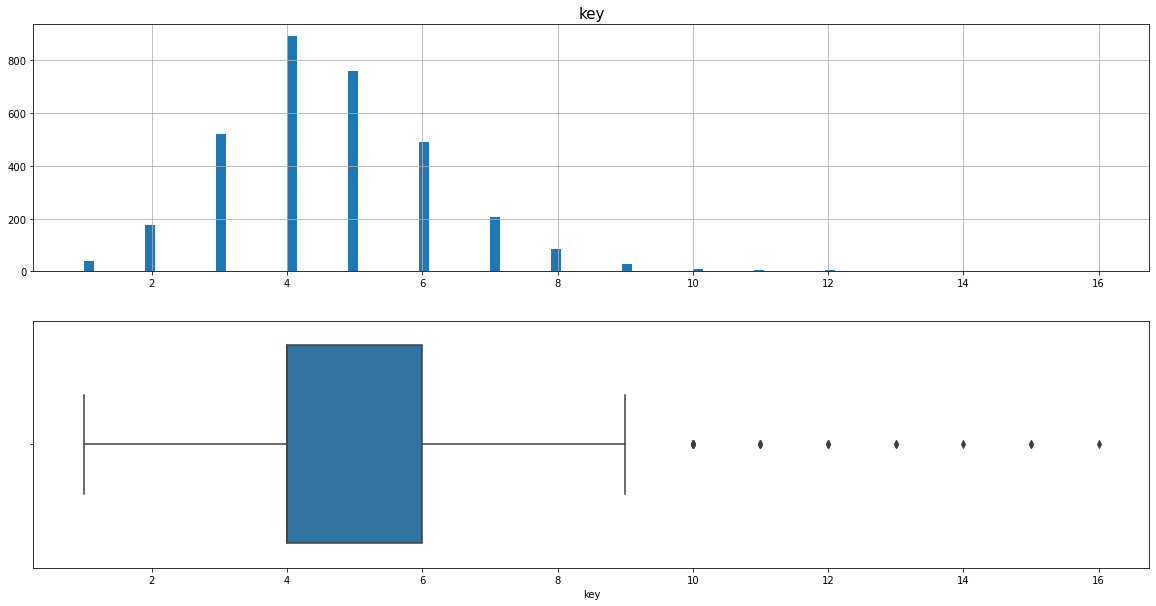

In [11]:
# посмотрим на распределение количества иттераций для столбца key
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
data_arc.key.value_counts().hist(bins=100)
plt.title('key', fontsize=15)
plt.subplot(2, 1, 2)
sns.boxplot(data_arc.key.value_counts())
plt.show()

In [7]:
# посмотрим количество уникальных значений в столбце key
data_arc.key.nunique()

3214

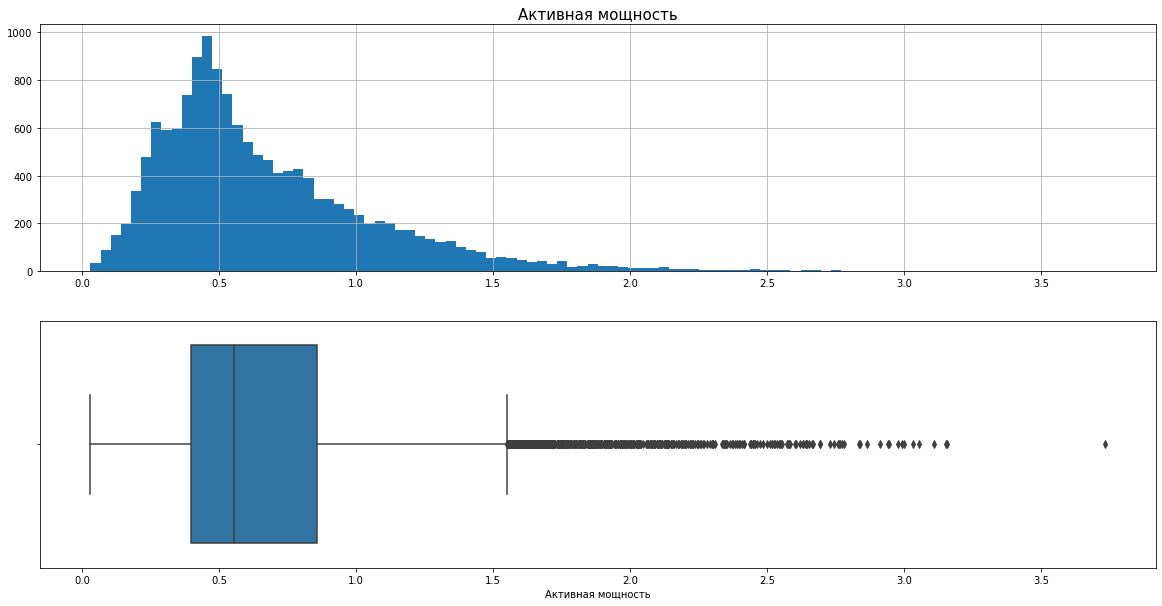

In [13]:
# построим гистограмму и boxplot для столбца "Активная мощность"
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
data_arc['Активная мощность'].hist(bins=100)
plt.title('Активная мощность', fontsize=15)
plt.subplot(2, 1, 2)
sns.boxplot(data_arc['Активная мощность'])
plt.show()

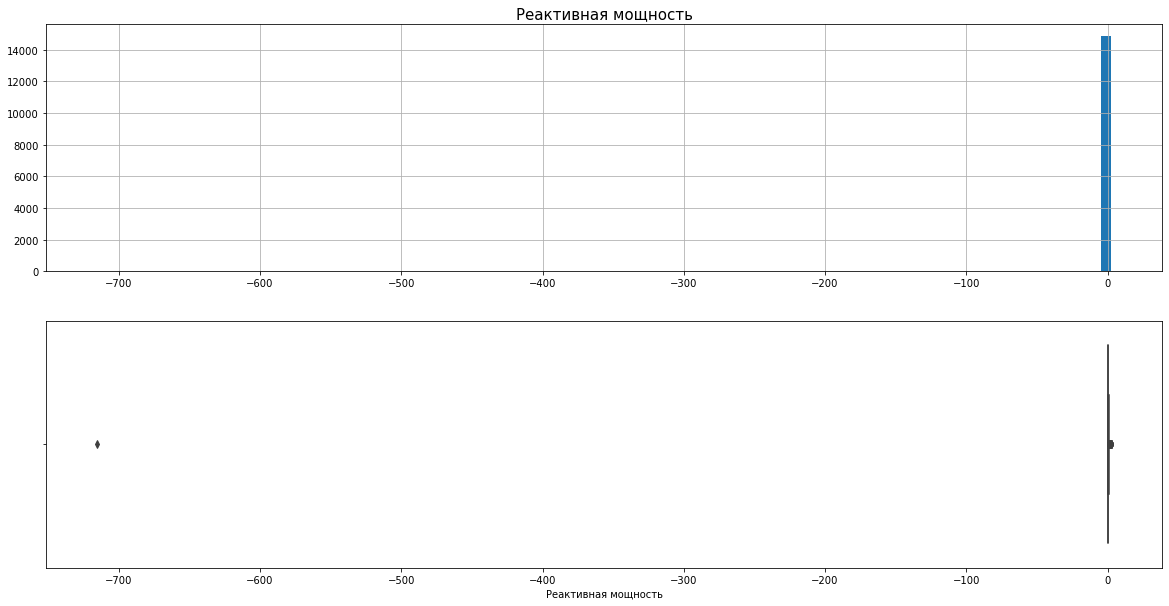

In [14]:
# построим гистограмму и boxplot для столбца "Реактивная мощность"
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
data_arc['Реактивная мощность'].hist(bins=100)
plt.title('Реактивная мощность', fontsize=15)
plt.subplot(2, 1, 2)
sns.boxplot(data_arc['Реактивная мощность'])
plt.show()

#### Вывод

На входе имеем датафрейм состоящий из четеырех столбцов, без пропусков и дубликатов. Признаки между собой имеют слабую зависимость. 

Рассмотрев распределения значений столбцов можно сделать следующие выводы:

* **"Key"** - содержит 3214 уникальных значений, которые из-за разного количества иттераций могут повторяться от 1 до 16 раз. Имеет нормальное распределение с пиком в 4 иттерации.


* **"Активная мощность"** - видим распределение с перекосом в левую сторону и модой значений в пределах 0.44 - 0.46. Начиная со значений 1.5 - 2 видим хвост выбросов, особенно привлекает внимание значение 3.731596, которое с большим отрывом опережает блишайших конкурентов, но так как по информации заказчика, что все данные в датафрейме корректные мы не будем исключать выбросы.


* **"Реактивная мощность"** - видим распределение с перекосом в левую сторону и модой значений в пределах 0.25 - 0.75, выбросов тут уже не так много, но есть отрицательные значения, чего быть не должно.

Что нужно сделать в предобработке:

1) Исключить отрицательные значения по столбцу "Реактивная мощность".

2) Добавить новый признак общая можность, расчитанный по формуле $S=\sqrt{P^2+Q^2}$, где: P — активная мощность,  Q — реактивная мощность.

3) Добовить столбец с длительностью нагрева с помощью разницы столбцов с началом нагрева и концом нагрева.

4) Сгруппировать датафрейм по значению key, в качестве агрегирующей функции использовать сумму, также добавить столбец с количеством иттераций для конкретного ключа.

5) Проверить датафрейм на мультиколлинеарность и удалить лишние признаки.



### Данные о подаче сыпучих материалов (объём)

In [10]:
# проведем первичный осмотр df с помощью заранее подготовленной функциии
df_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Количество пропусков:

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Количество дубликатов:
0
Описание данных:
               key      Bulk 1      Bulk 2       Bulk 3       Bulk 4  \
count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
std     933.337642   18.277654   21.180578    75.483494    48.184126   
min       1.000000   10.000000  228.000000     6.000000    12.000000   
25%     816.000000   27.000000  242.000000    58.000000    72.000000   
50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
max    3241.000000  185.000000  325.000000   454.000000   281.000000   

           Bulk

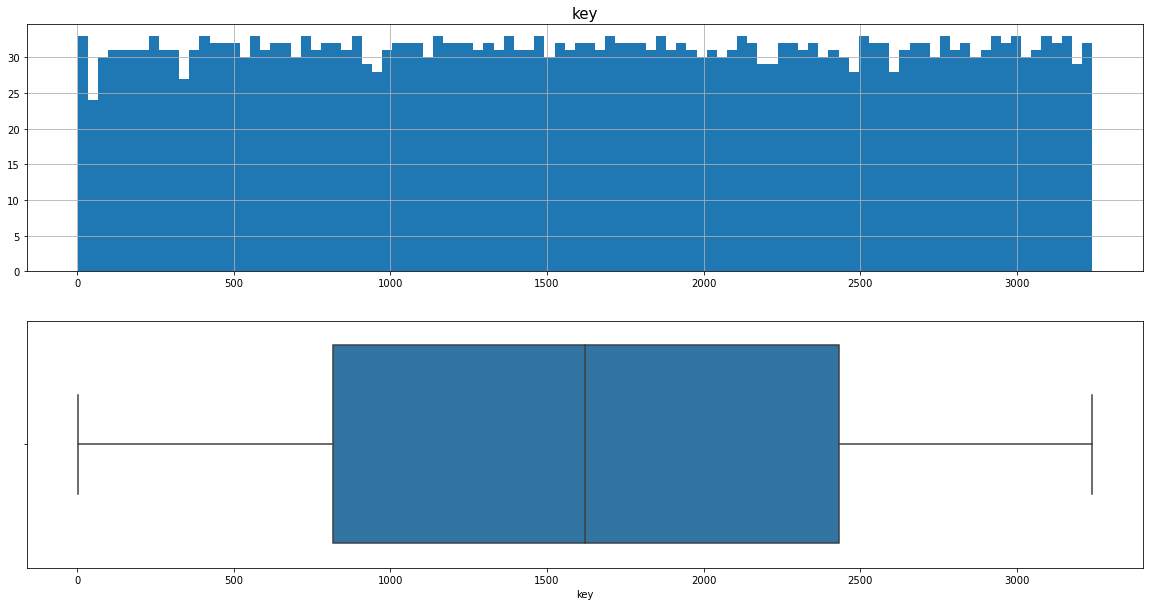

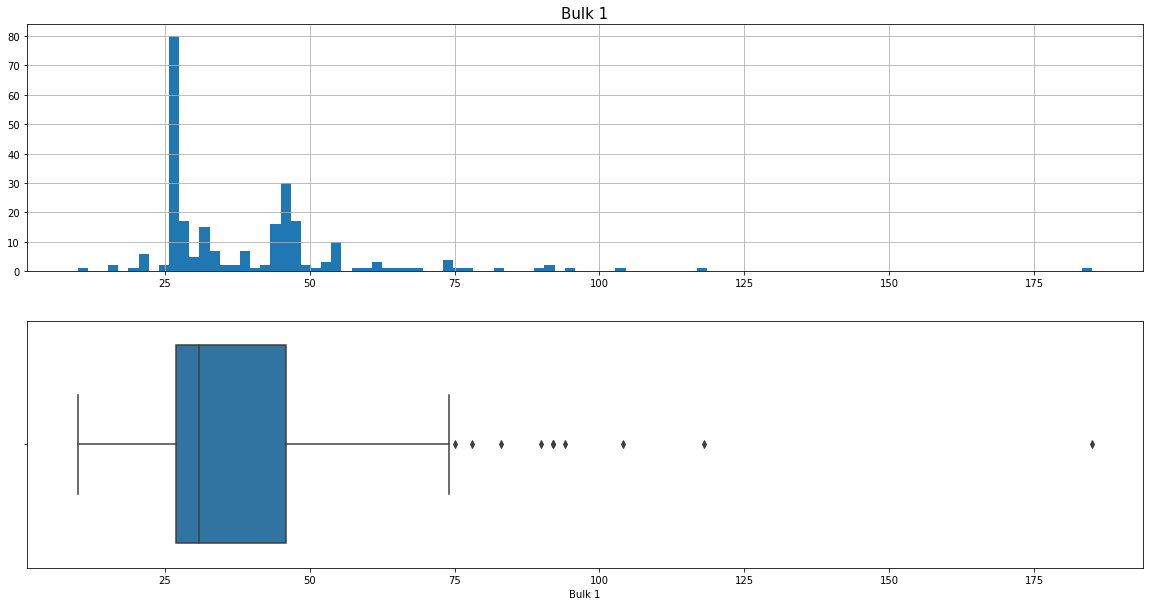

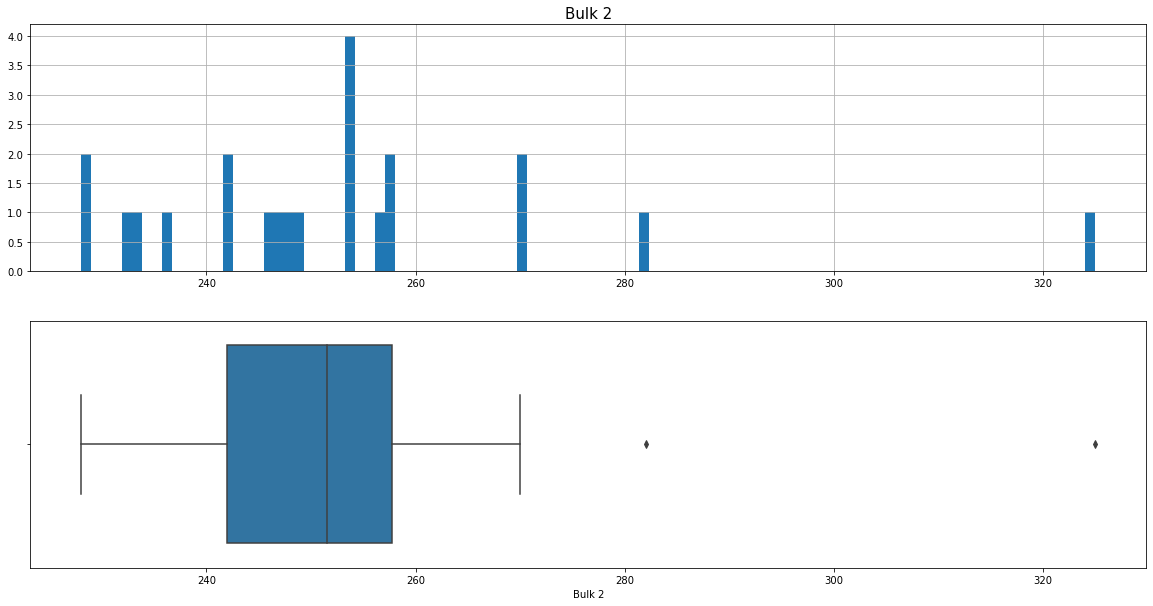

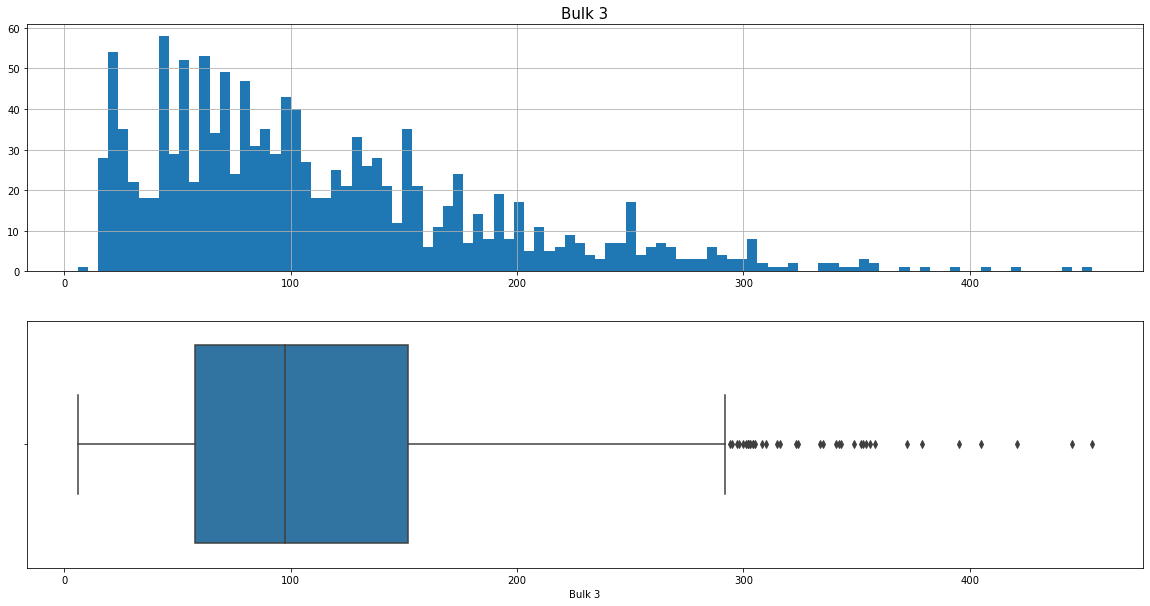

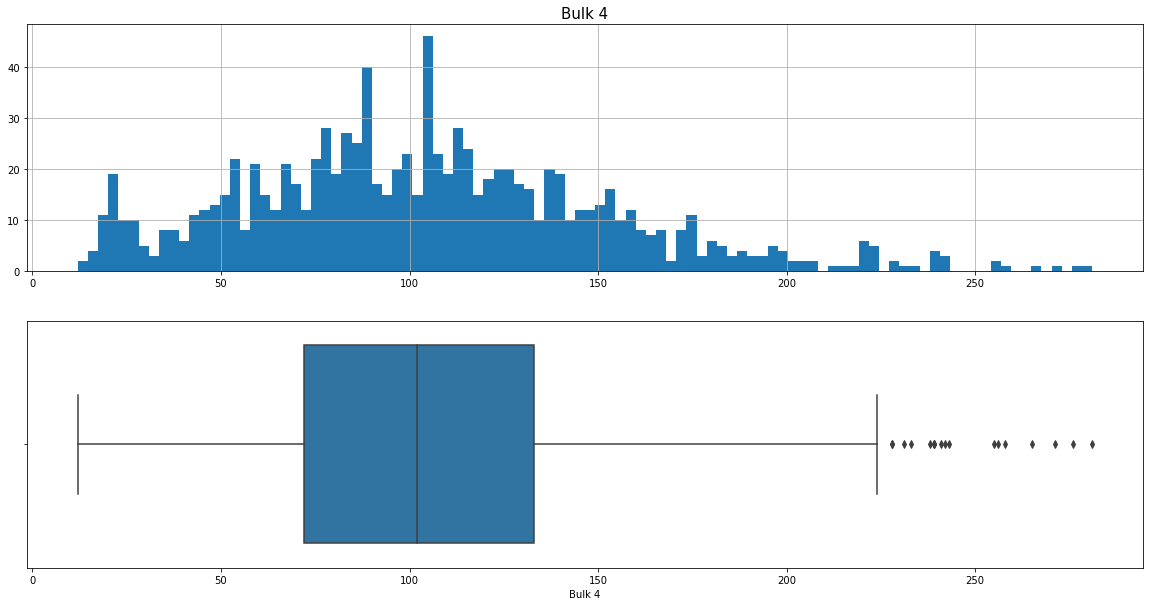

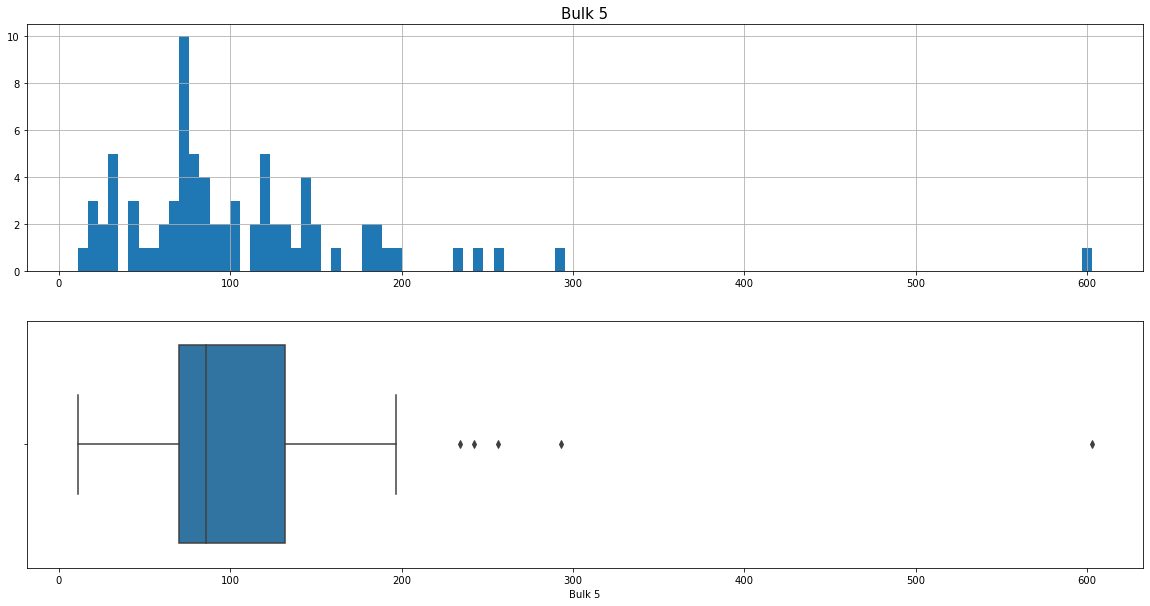

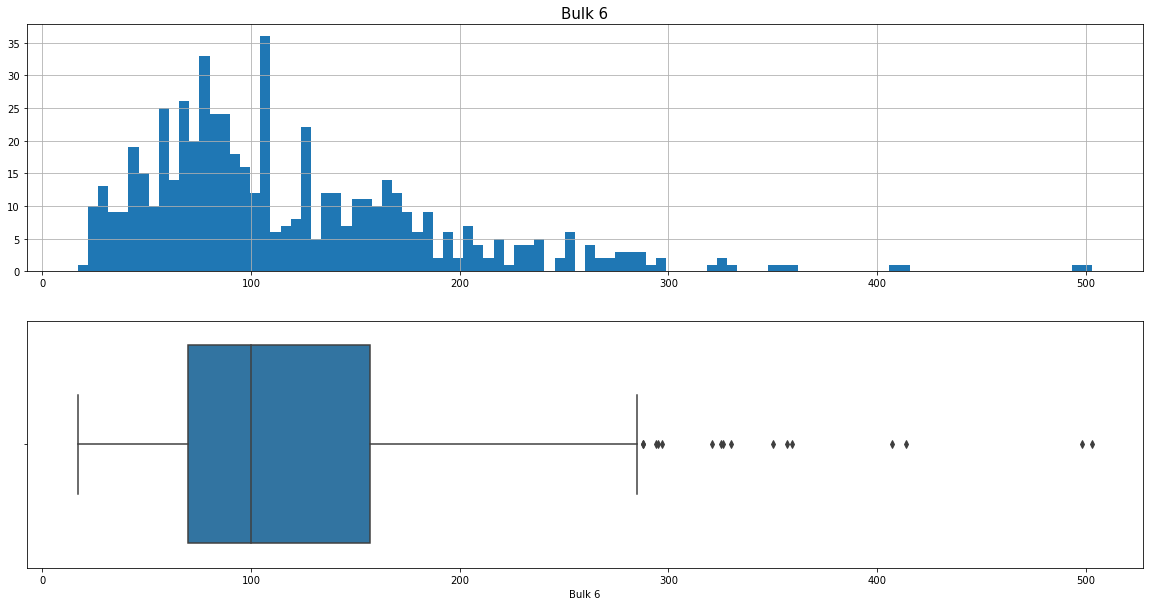

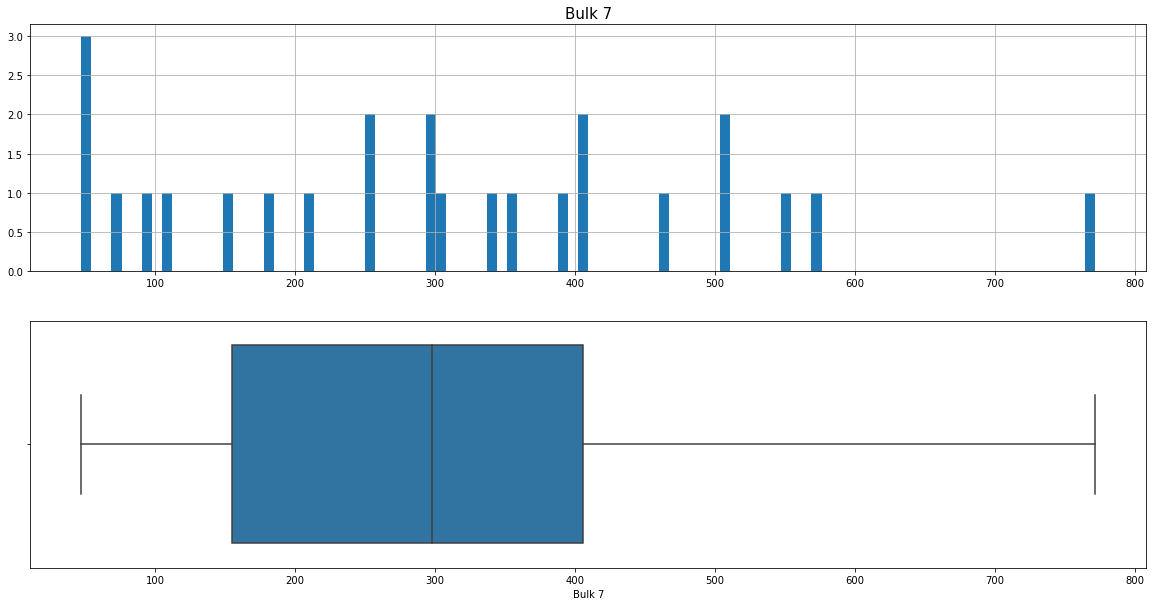

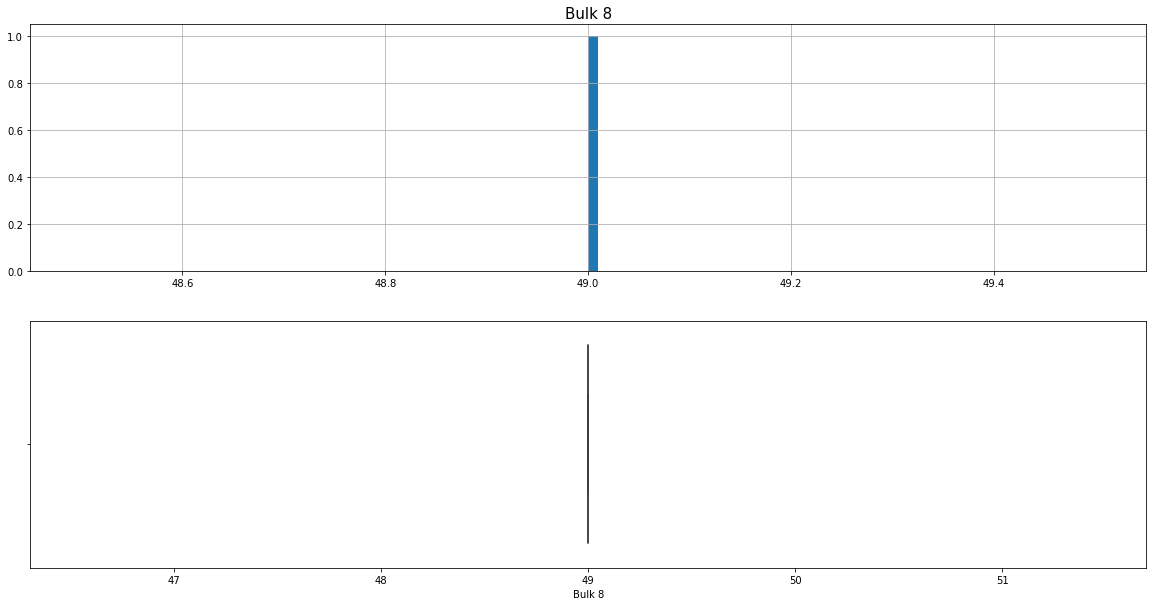

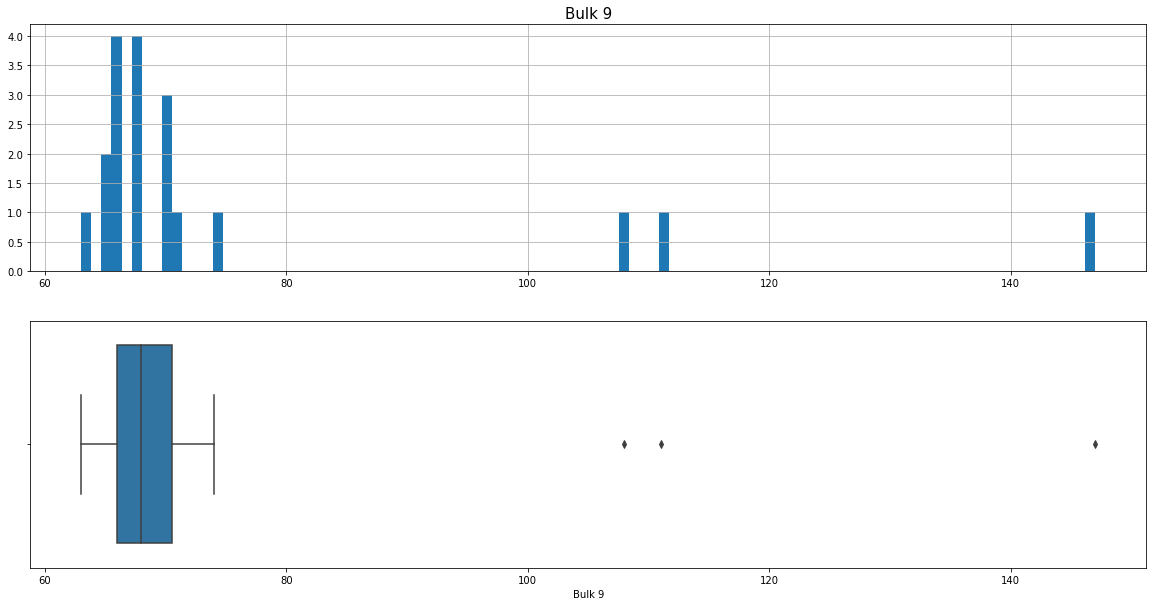

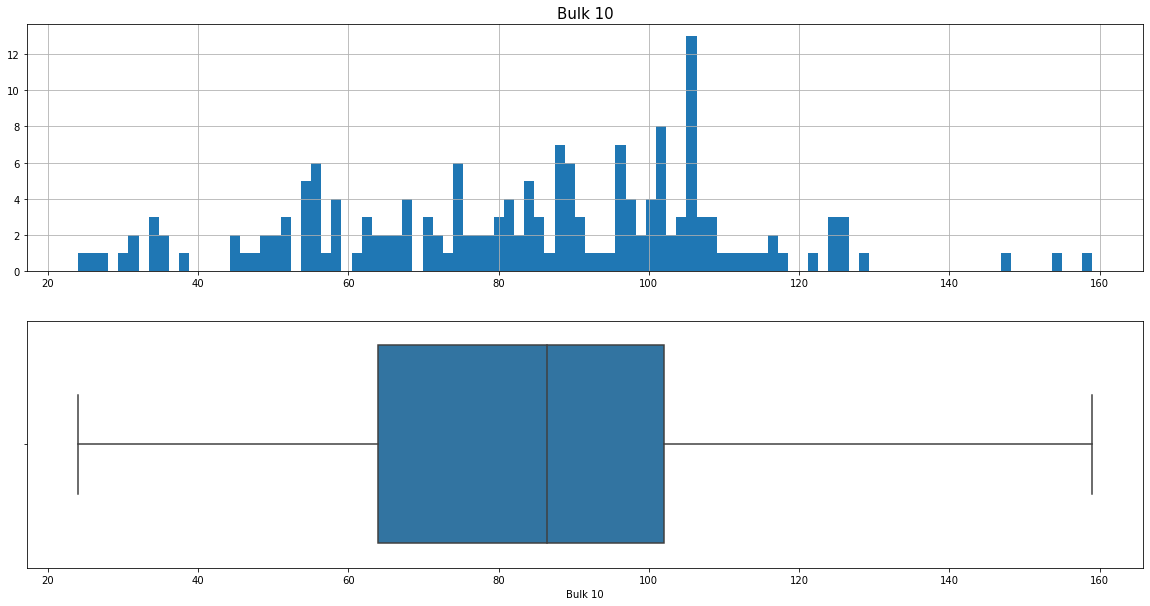

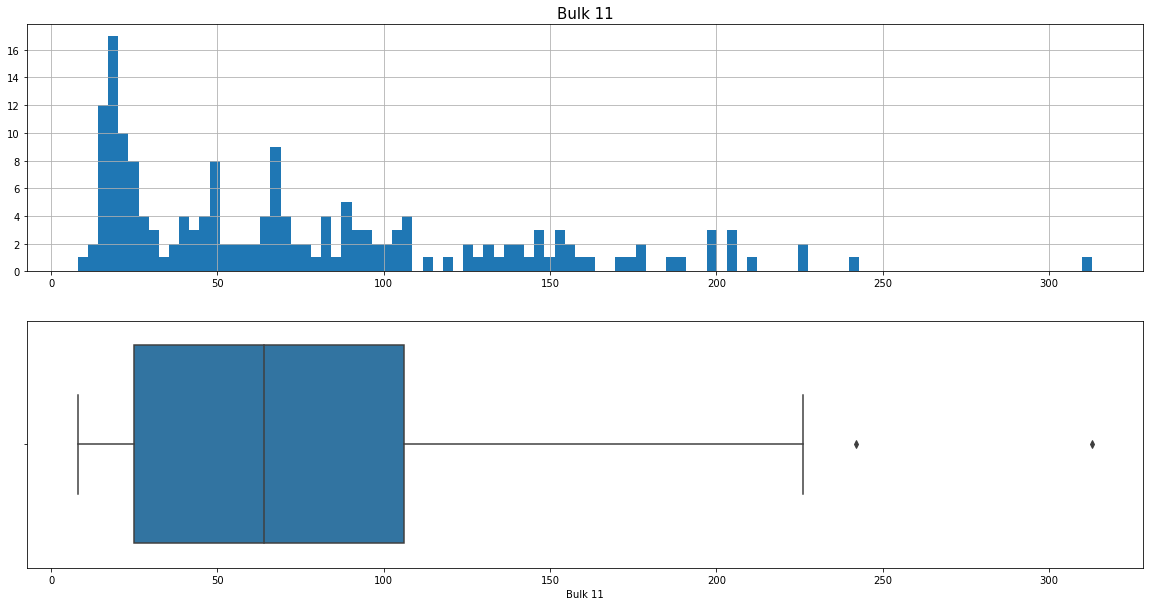

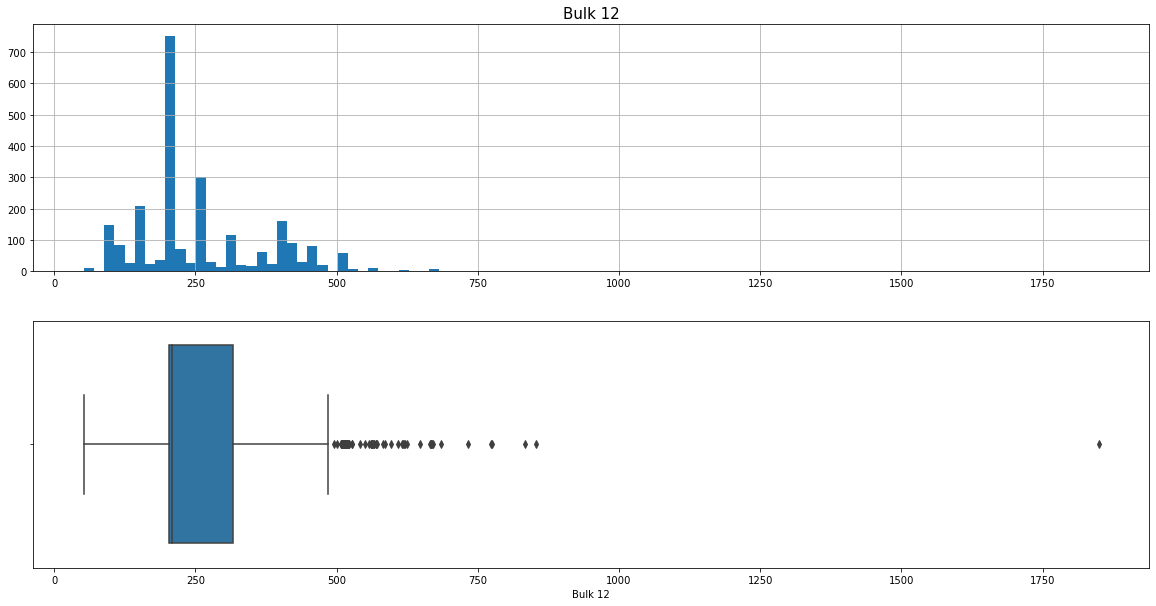

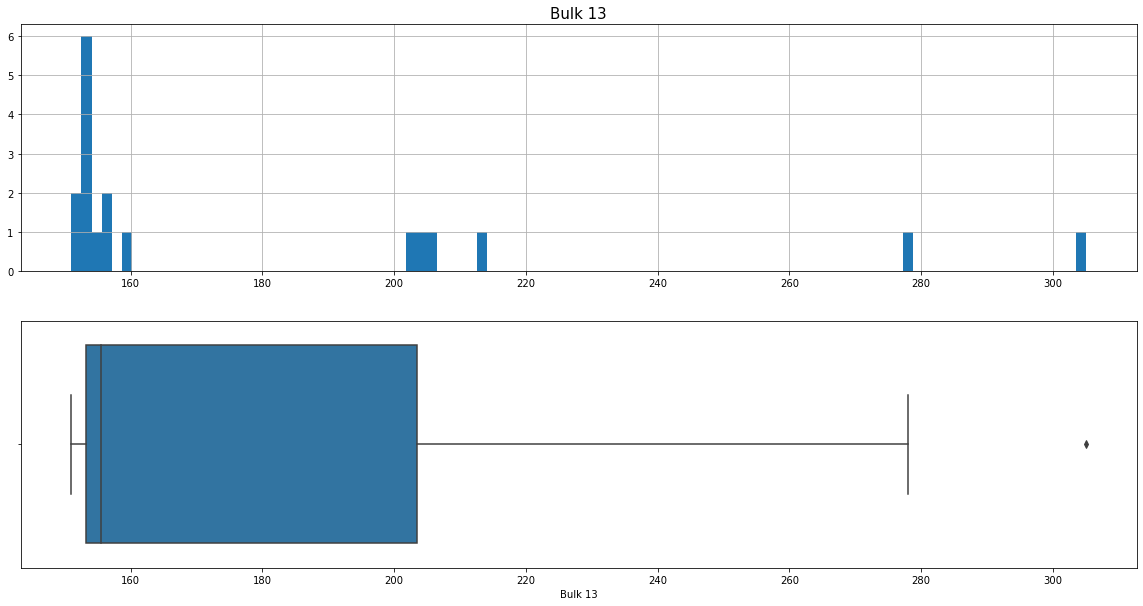

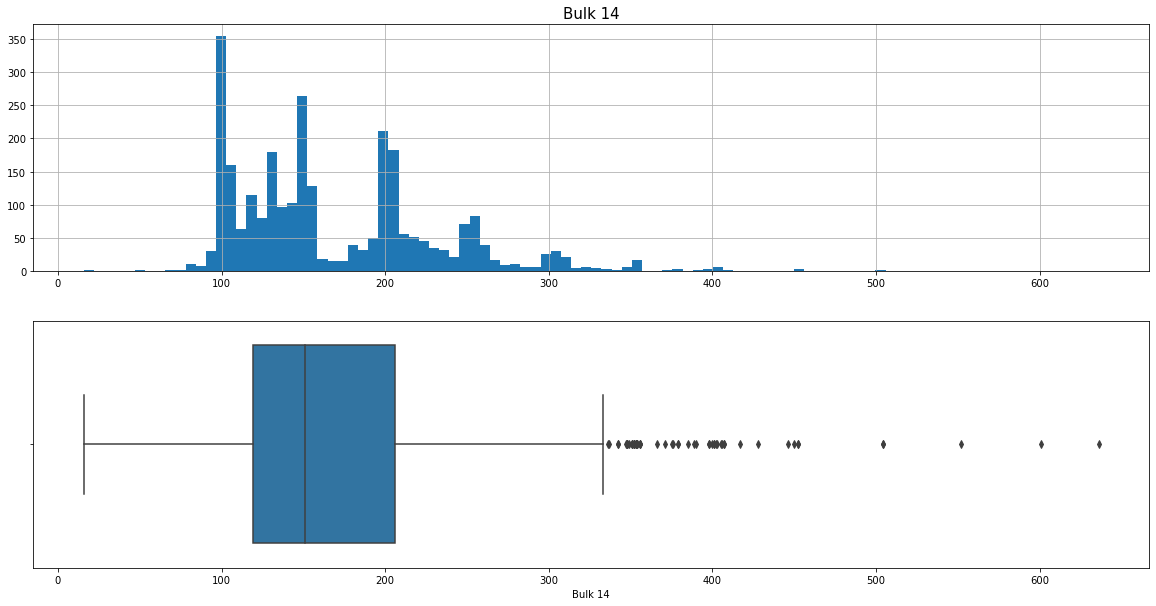

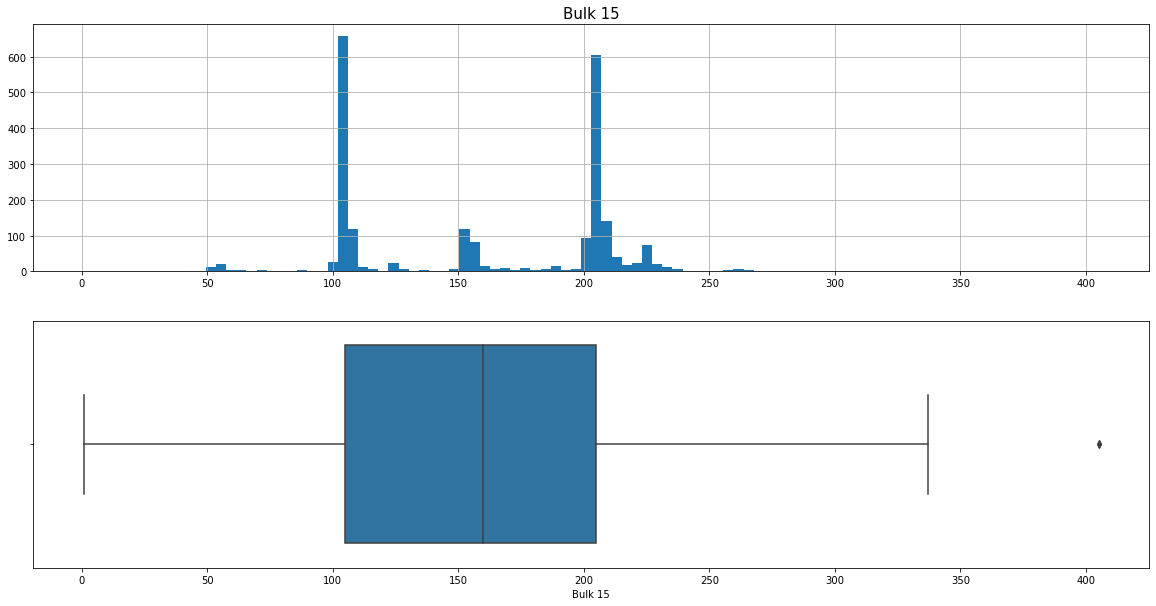

In [15]:
# посмотрим на распределения значений для столбцов исходного df
for i in data_bulk.columns: 
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    data_bulk[i].hist(bins=100)
    plt.title(i, fontsize=15)
    plt.subplot(2, 1, 2)
    sns.boxplot(data_bulk[i])
    plt.show()

In [12]:
#посмотрим количество уникальных значений в столбце key
data_bulk.key.nunique()

3129

#### Вывод

На входе имеем датафрейм 16 столбцов, дубликатов нет, но очень много пропусков. Некоторые признаки имеют довольно высокую зависимость между собой - Bulk 9 и Bulk 12(0.946954), Bulk 6 и Bulk 13(0.844690). 3129 уникальных значений в столбце key, которые встречаются только по одному разу. В некоторых столбцах данные присутствуют для малого количества строк, мы можем это объснить спецификой производства, но столбец Bulk 8 имеет лишь одно значение, поэтому удалим его при подготовке выборок.

Что нужно сделать в предобработке:

1) ввиду специфики производства заполним пропуски 0.

2) удалить один из признаков Bulk 9 и Bulk 12 ввиду высокой корреляции.

3) удалить признак Bulk 8.

### Данные о подаче сыпучих материалов (время)

In [13]:
# проведем первичный осмотр df с помощью заранее подготовленной функциии
df_info(data_bulk_time)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:21:30,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:03:52,NaT,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaT,NaT,NaT,2019-05-03 11:46:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:40:20,NaT,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaT,NaT,NaT,2019-05-03 12:31:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:09:40,NaT,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaT,NaT,NaT,2019-05-03 12:48:43,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:41:24,NaT,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaT,NaT,NaT,2019-05-03 13:18:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:12:56,NaT,2019-05-03 13:12:56,2019-05-03 13:12:56



Количество пропусков:

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Количество дубликатов:
0
Описание данных:
               key
count  3129.000000
mean   1624.383509
std     933.337642
min       1.000000
25%     816.000000
50%    1622.000000
75%    2431.000000
max    3241.000000

Корреляция:
     key
key  1.0


In [14]:
# рассмотрим минимальное и максимальное значение каждой колонки df на предмет поиска аномалий 
for i in data_bulk_time.columns:
    print(i)
    print()
    print(data_bulk_time[i].min())
    print(data_bulk_time[i].max())
    print('######################')
    print()

key

1
3241
######################

Bulk 1

2019-05-03 17:50:19
2019-08-30 23:01:32
######################

Bulk 2

2019-05-07 08:36:19
2019-08-08 17:34:38
######################

Bulk 3

2019-05-03 20:13:36
2019-08-31 23:39:11
######################

Bulk 4

2019-05-03 11:21:30
2019-08-30 17:36:30
######################

Bulk 5

2019-05-07 08:36:19
2019-08-28 09:01:08
######################

Bulk 6

2019-05-03 18:52:57
2019-09-01 03:12:40
######################

Bulk 7

2019-05-07 11:37:42
2019-08-31 07:22:25
######################

Bulk 8

2019-07-05 17:46:11
2019-07-05 17:46:11
######################

Bulk 9

2019-05-14 00:04:56
2019-08-11 15:09:33
######################

Bulk 10

2019-05-06 01:36:24
2019-08-30 01:30:42
######################

Bulk 11

2019-05-05 16:45:05
2019-08-31 16:00:49
######################

Bulk 12

2019-05-03 11:03:52
2019-09-01 01:39:41
######################

Bulk 13

2019-05-05 00:39:35
2019-08-26 20:31:16
######################

Bulk 14

2019-05-03 11:0

#### Вывод

Датафрейм очень похож на предыдущий, только в качестве значений у нас выступают дата и время, количество пропусков совпадает, дубликатов нет. Аномальных значений даты нет. Ввиду того, что мы не работаем с временными рядами данные признаки для нас не интересны.

### Данные о продувке сплава газом

In [15]:
# проведем первичный осмотр df с помощью заранее подготовленной функциии
df_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Количество пропусков:

key      0
Газ 1    0
dtype: int64

Количество дубликатов:
0
Описание данных:
               key        Газ 1
count  3239.000000  3239.000000
mean   1621.861377    11.002062
std     935.386334     6.220327
min       1.000000     0.008399
25%     812.500000     7.043089
50%    1622.000000     9.836267
75%    2431.500000    13.769915
max    3241.000000    77.995040

Корреляция:
            key     Газ 1
key    1.000000 -0.040655
Газ 1 -0.040655  1.000000


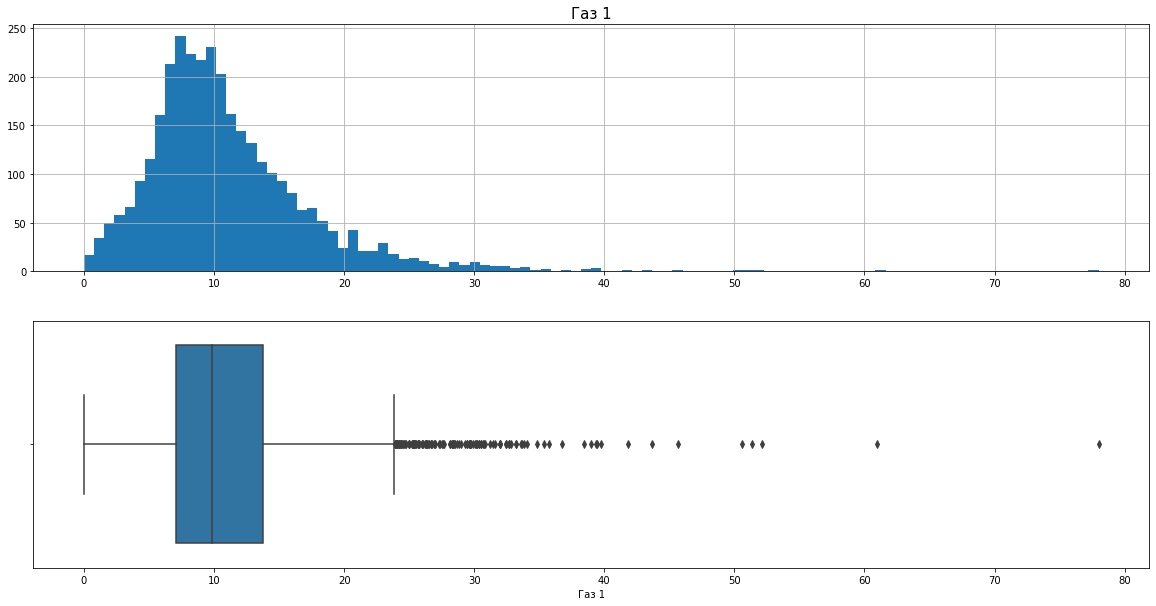

In [16]:
# посмотрим на распределения значений для столбцов исходного df

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
data_gas['Газ 1'].hist(bins=100)
plt.title('Газ 1', fontsize=15)
plt.subplot(2, 1, 2)
sns.boxplot(data_gas['Газ 1'])
plt.show()

In [17]:
#посмотрим количество уникальных значений в столбце key
data_gas['Газ 1'].nunique()

3239

#### Вывод

На входе имеем датафрейм состоящий из двух столбцов, пропусков и дубликатов нет. Распределение близкое к нормальному, с хвостом выбросов в правую сторону. Здесь также наблюдаем несколько аномально больших значений объемов газа(относительно всего df), но их мы также считаем особенностями технического процесса, поэтому убирать их из выборки не будем.

### Данные о проволочных материалах (объём)

In [18]:
df_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Количество пропусков:

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Количество дубликатов:
0
Описание данных:
               key       Wire 1       Wire 2      Wire 3      Wire 4  Wire 5  \
count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
mean   1623.426485   100.895853    50.577323  189.482681   57.442842  15.132   
std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   

           Wire 6     Wire 7      Wire 8     Wire

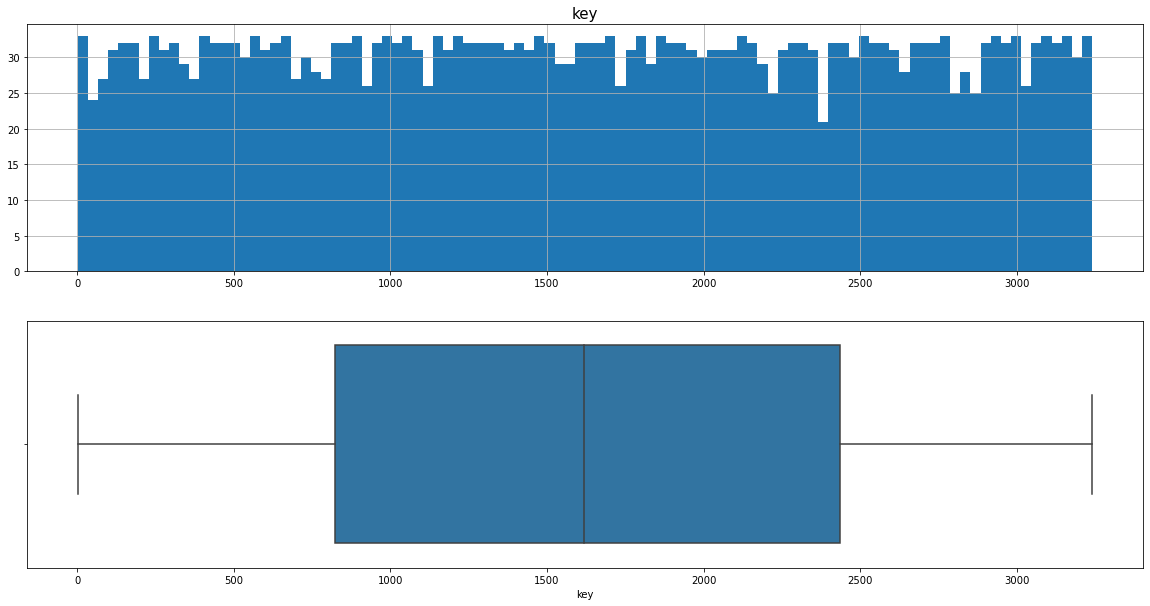

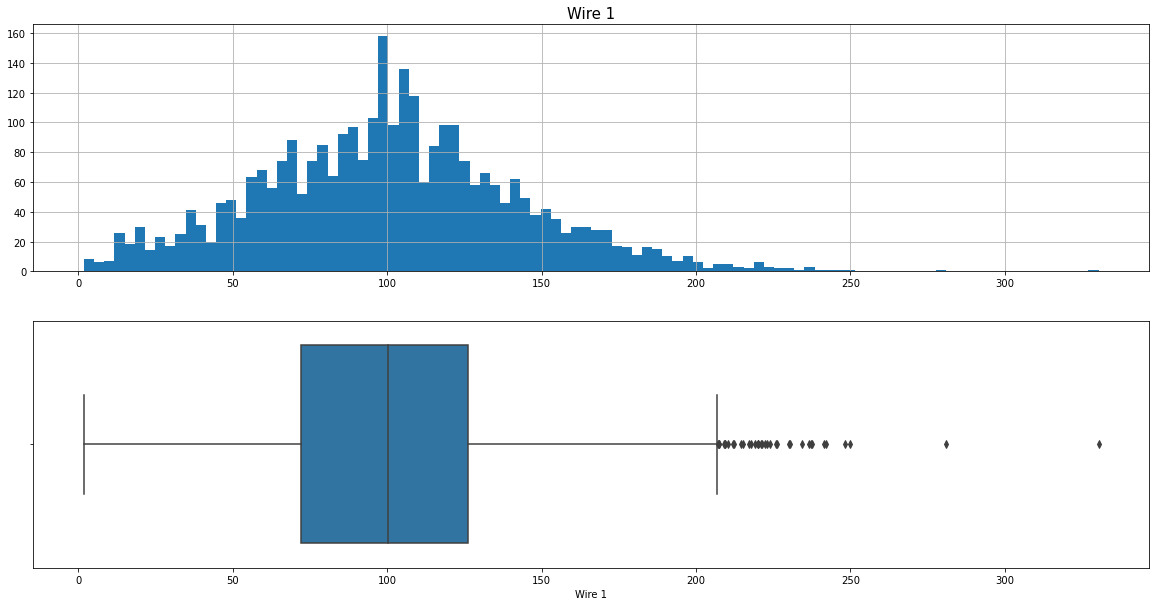

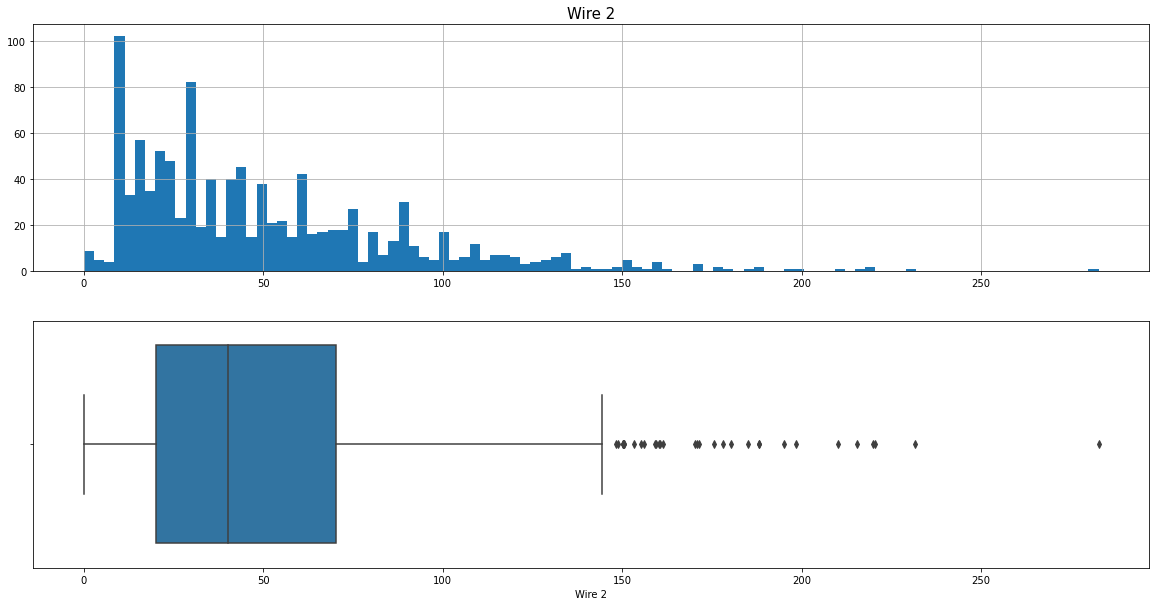

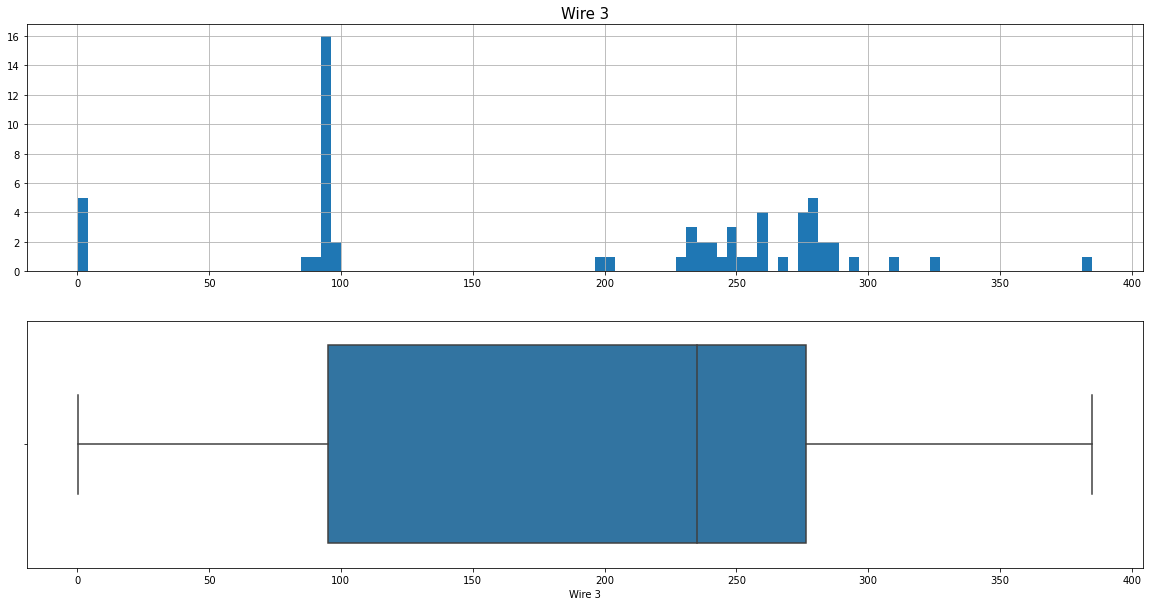

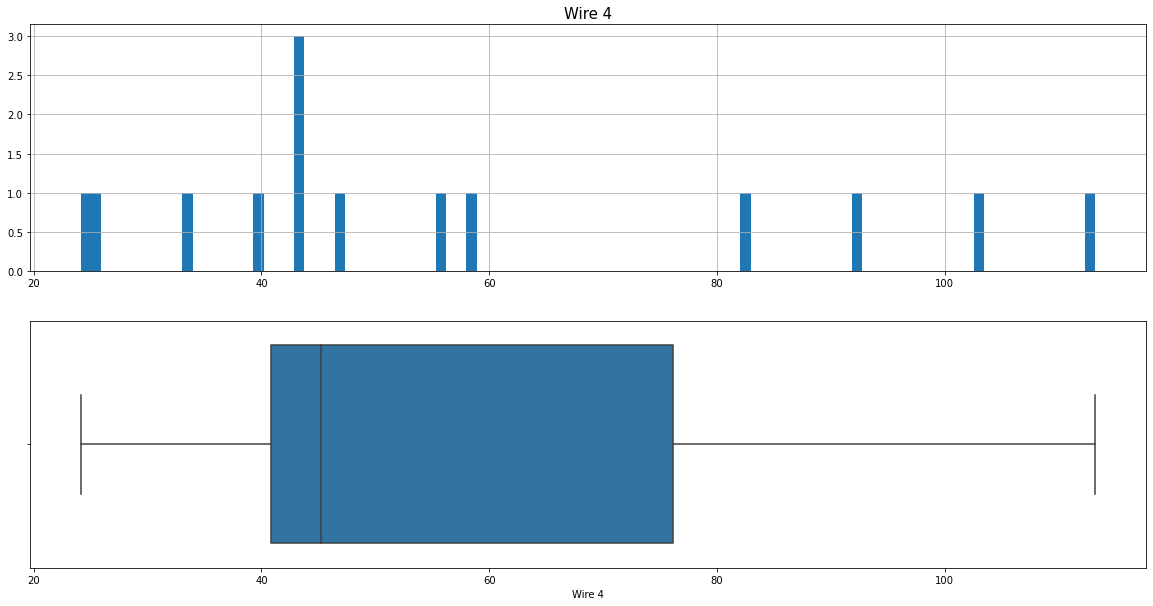

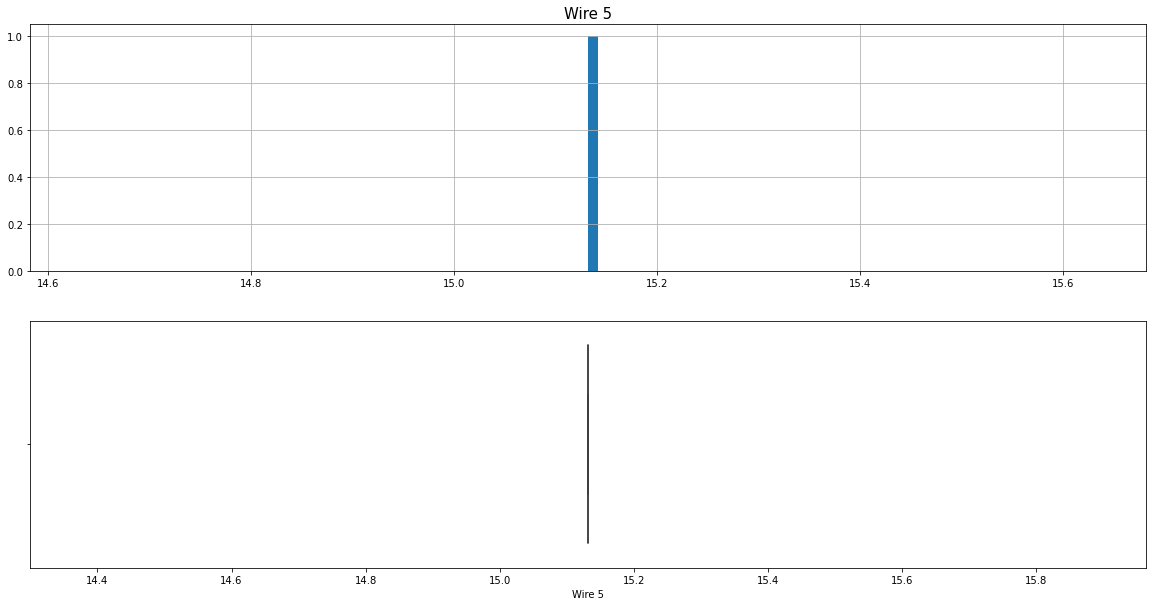

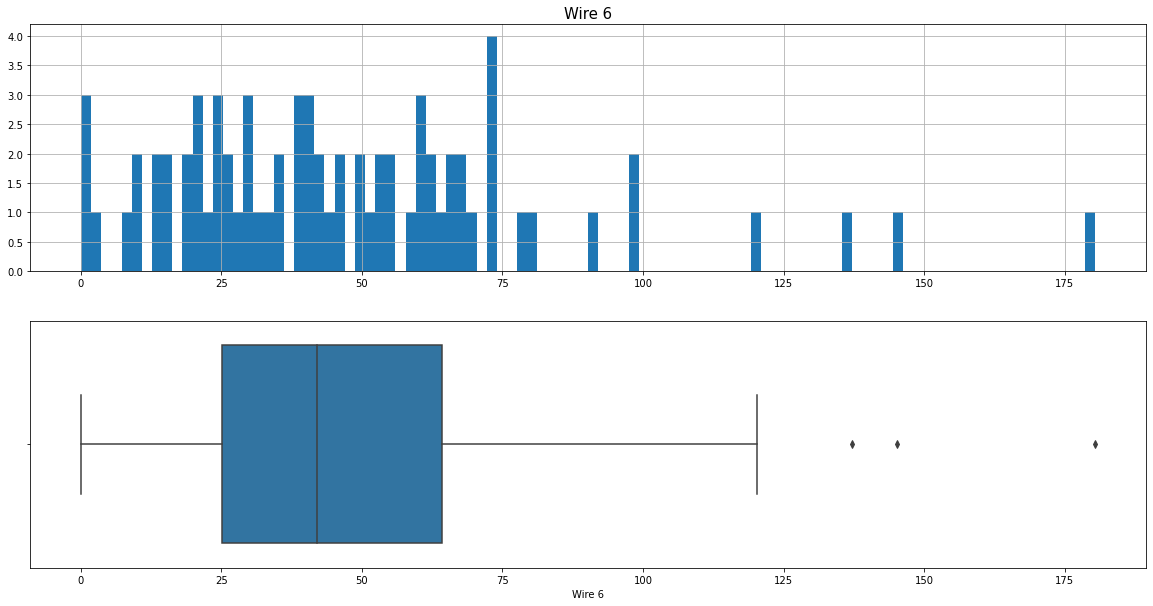

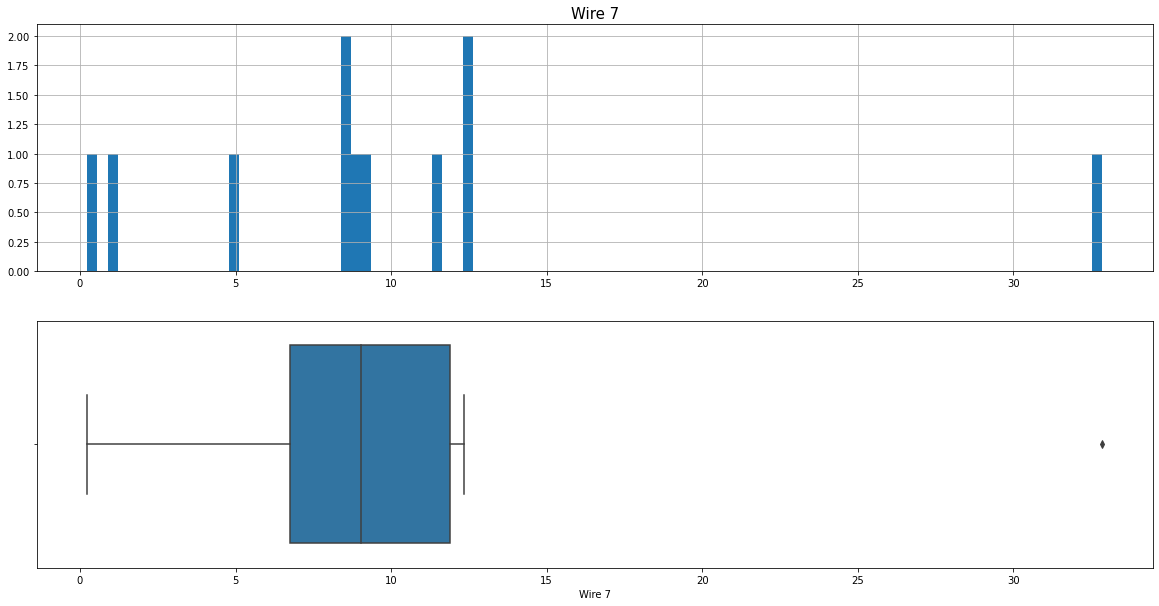

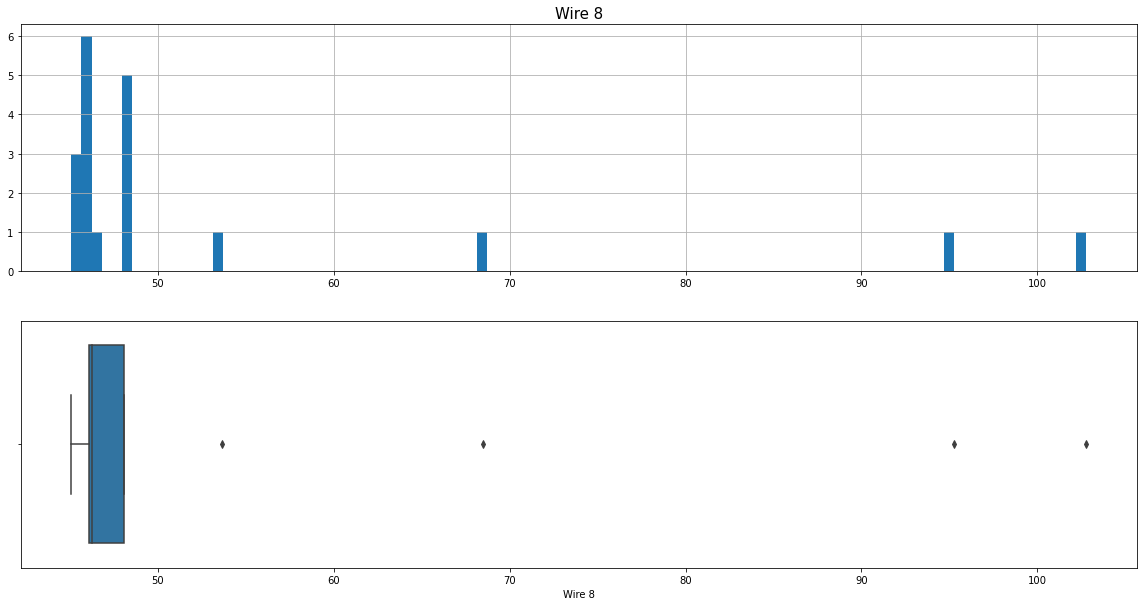

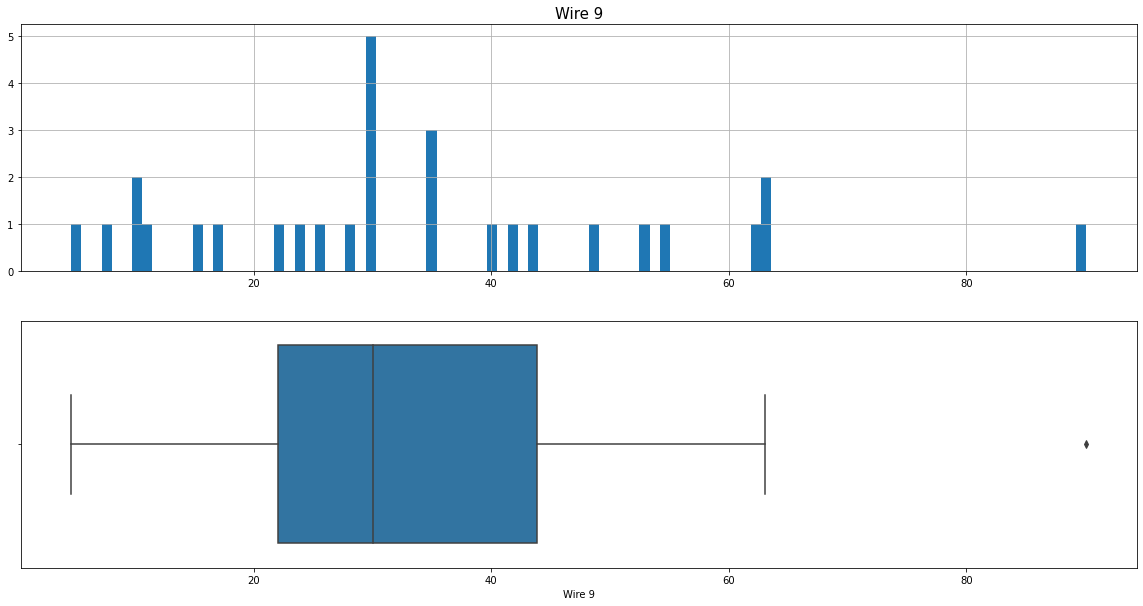

In [17]:
# посмотрим на распределения значений для столбцов исходного df
for i in data_wire.columns: 
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 1, 1)
    data_wire[i].hist(bins=100)
    plt.title(i, fontsize=15)
    plt.subplot(2, 1, 2)
    sns.boxplot(data_wire[i])
    plt.show()

In [20]:
#посмотрим количество уникальных значений в столбце key
data_wire.key.nunique()

3081

#### Вывод

На входе имеем датафрейм 10 столбцов, дубликатов нет, но очень много пропусков. 3081 уникальных значений в столбце key, которые встречаются только по одному разу. В некоторых столбцах данные присутствуют для малого количества строк, мы можем это объснить спецификой производства, но столбец Wire 5 имеет лишь одно значение, поэтому удалим его при подготовке выборок.

Что нужно сделать в предобработке:

1) ввиду специфики производства заполним пропуски 0.

2) удалить признак Wire 5.

### Данные о проволочных материалах (время)

In [21]:
# проведем первичный осмотр df с помощью заранее подготовленной функциии
df_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:46:10,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:13:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:48:05,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaT,NaT,NaT,NaT,NaT,NaT,NaT



Количество пропусков:

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

Количество дубликатов:
0
Описание данных:
               key
count  3081.000000
mean   1623.426485
std     932.996726
min       1.000000
25%     823.000000
50%    1619.000000
75%    2434.000000
max    3241.000000

Корреляция:
     key
key  1.0


In [22]:
# рассмотрим минимальное и максимальное значение каждой колонки df на предмет поиска аномалий 
for i in data_wire_time.columns:
    print(i)
    print()
    print(data_wire_time[i].min())
    print(data_wire_time[i].max())
    print('######################')
    print()

key

1
3241
######################

Wire 1

2019-05-03 11:11:41
2019-09-01 04:16:01
######################

Wire 2

2019-05-03 13:32:06
2019-08-31 18:50:15
######################

Wire 3

2019-05-04 04:47:53
2019-08-28 02:11:18
######################

Wire 4

2019-05-07 08:48:23
2019-08-08 12:03:12
######################

Wire 5

2019-08-08 16:01:07
2019-08-08 16:01:07
######################

Wire 6

2019-05-07 08:37:20
2019-08-14 00:59:11
######################

Wire 7

2019-07-23 12:08:44
2019-08-08 18:27:34
######################

Wire 8

2019-05-14 00:03:32
2019-08-11 15:09:29
######################

Wire 9

2019-05-04 16:09:11
2019-08-29 03:51:31
######################



#### Вывод

Датафрейм очень похож на предыдущий, только в качестве значений у нас выступают дата и время, количество пропусков совпадает, дубликатов нет. Аномальных значений даты нет. Ввиду того, что мы не работаем с временными рядами данные признаки для нас не интересны.

### Результаты измерения температуры

In [20]:
# проведем первичный осмотр df с помощью заранее подготовленной функциии
df_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0



Количество пропусков:

key                0
Время замера       0
Температура     2901
dtype: int64

Количество дубликатов:
0
Описание данных:
                key   Температура
count  15907.000000  13006.000000
mean    1607.880870   1591.840920
std      942.212073     21.375851
min        1.000000   1191.000000
25%      790.000000   1581.000000
50%     1618.000000   1591.000000
75%     2427.000000   1601.000000
max     3241.000000   1705.000000

Корреляция:
                  key  Температура
key          1.000000    -0.046895
Температура -0.046895     1.000000


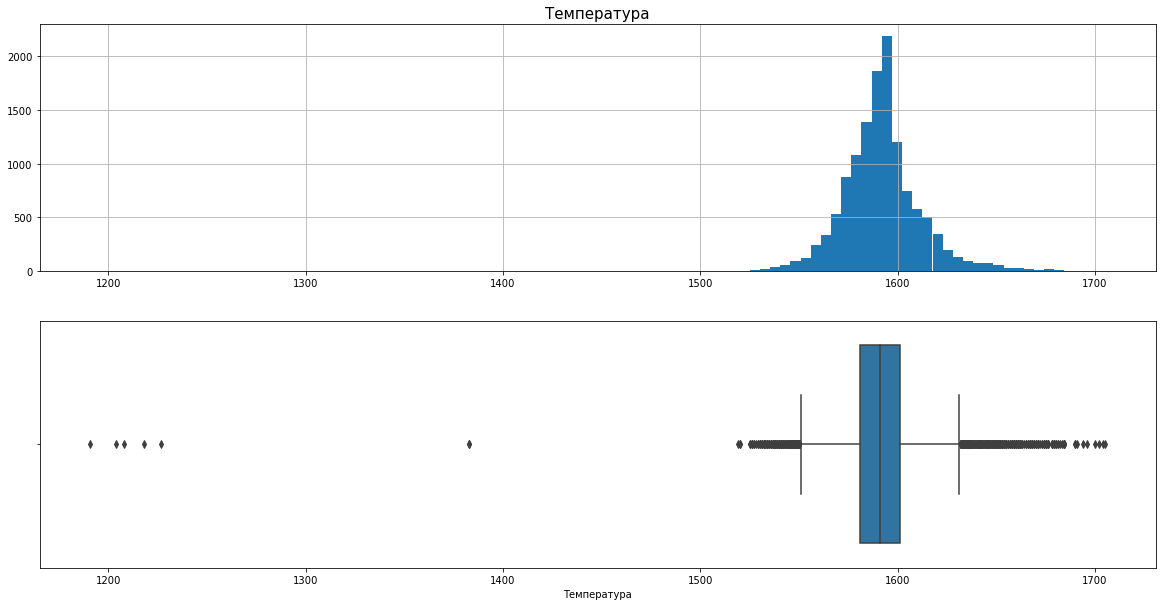

In [21]:
# посмотрим на распределение значений температуры
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
data_temp['Температура'].hist(bins=100)
plt.title('Температура', fontsize=15)
plt.subplot(2, 1, 2)
sns.boxplot(data_temp['Температура'])
plt.show()

In [22]:
# сгруппируем данные по ключу и посчитаем количество измерений температуры
data_temp_group = data_temp.groupby('key', as_index=False) \
                 .agg(count_key = ('Температура', 'count')) \
                 .sort_values('key')
data_temp_group.head() 

,key,count_key
0,1,5
1,2,6
2,3,5
3,4,3
4,5,2


<AxesSubplot:xlabel='key', ylabel='count_key'>

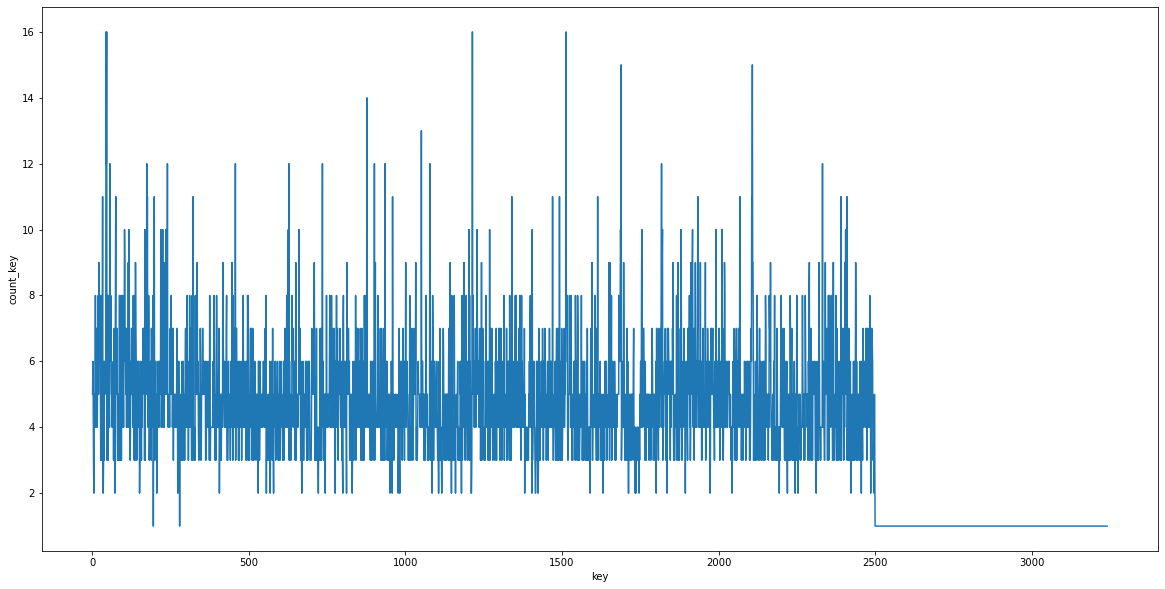

In [25]:
# построим график количества измерений температуры
plt.figure(figsize=(20, 10))
sns.lineplot(x =data_temp_group['key'], 
              y=data_temp_group['count_key'], 
              )

#### Вывод

На входе имеем датафрейм из трех столбцов, в котором нет дубликатов, но есть пропуски в столбце 'Температура' - 2901. Рассмотрев распределение значений по температуре мы видим близкое к нормальному распределение с большим хвостом выбросов в левую сторону. Данные выбросы рассматриваем как особенности технологического процесса и не будем их удалять. 

Также рассмотрев график количества измерений температуры мы видим, далеко не все ключи имеют начальную и конечную температуры, поэтому из df нужно убрать ключи 195, 279, а также ключи, которые больше или равны 2500.

Что нужно делать в предобработке:

1) Сгрупировать данные по ключу и выделить начальную и конечную теспературы.

2) Оставить только те ключи, в которых есть и начальная, и конечная температуры.

# План

* **Исследовательский анализ данных** - описан выше.


* **Предобработка данных:**

   **для data_arc**
   
    1) Исключить отрицательные значения по столбцу "Реактивная мощность".

    2) Добавить новый признак общая можность, расчитанный по формуле $S=\sqrt{P^2+Q^2}$, где: P — активная мощность,  Q — реактивная мощность.

    3) Добовить столбец с длительностью нагрева с помощью разницы столбцов с началом нагрева и концом нагрева.

    4) Сгруппировать датафрейм по значению key, в качестве агрегирующей функции использовать сумму, также добавить столбец с количеством иттераций для конкретного ключа.

    5) Проверить датафрейм на мультиколлинеарность и удалить лишние признаки.
    
    **для data_bulk**
    
    1) ввиду специфики производства заполним пропуски 0.

    2) удалить один из признаков Bulk 9 и Bulk 12 ввиду высокой корреляции.

    3) удалить признак Bulk 8.
    
    **для data_wire**
    
    1) ввиду специфики производства заполним пропуски 0.

    2) удалить признак Wire 5.
    
    **для data_temp**
    
    1) Сгруппировать данные по ключу и выделить начальную и конечную теспературы.

    2) Оставить только те ключи, в которых есть и начальная, и конечная температуры.
    
***Далее объединяем все df(кроме data_bulk_time,data_wire_time) через INNER JOIN, что бы остались только те значения, которые присутствую во всех df.***
   
   
* **Обучение моделей**

    1)Делим данные на обучающую и тестовую выборки.
    
    2) Проводим масштабирование признаков.
    
    3) Выделяем целевой и остальные признаки.
    
    4) Обучение 2-3 моделей и подбор гиперпараметров с помощью GridSearchCV.
    
    5) Проверка на тестовой выборке лучшей модели.
    
    
* **Общий вывод**

## Предобработка данных

### Результаты измерения температуры

In [27]:
# берем ранее подготовленную таблицу с количеством измерений температуры
display(data_temp_group.head(10))
data_temp_group.shape

,key,count_key
0,1,5
1,2,6
2,3,5
3,4,3
4,5,2
5,6,5
6,7,5
7,8,4
8,9,5
9,10,8


(3216, 2)

In [28]:
# фильтруем таблицу по количеству измерений = не менее 2
data_temp_group = data_temp_group.query('count_key >= 2')
display(data_temp_group.head(10))
data_temp_group.shape

,key,count_key
0,1,5
1,2,6
2,3,5
3,4,3
4,5,2
5,6,5
6,7,5
7,8,4
8,9,5
9,10,8


(2475, 2)

In [29]:
# сгруппируем начальный df по key и найдем первое и последнее измерение температуры
temp = data_temp \
      .groupby(by = 'key', as_index=False) \
      .agg(['first', 'last']) \
      .reset_index()

temp.columns = ['key',2,3,'first_temp','last_temp']
temp = temp[['key', 'first_temp', 'last_temp']]

print(temp.shape)
temp.head()

(3216, 3)


,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


In [30]:
# фильтруем temp так, чтобы там остались ключи, для которых как минимум 2 раза измерялась температура
temp_final = temp.loc[temp.key.isin(data_temp_group.key) == True]
print(temp_final.shape)
temp_final.head(10)

(2475, 3)


,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
5,6,1543.0,1596.0
6,7,1586.0,1599.0
7,8,1577.0,1598.0
8,9,1587.0,1592.0
9,10,1574.0,1593.0


### Данные об электродах

In [31]:
# данные по исходному df
print(data_arc.shape)
data_arc.head(10)

(14876, 5)


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


In [32]:
# убираем ключ с отрицательной реактивной мощностью
data_arc = data_arc[data_arc['Реактивная мощность'] >= 0]
data_arc.shape

(14875, 5)

In [33]:
# добавляем признак полная мощность
data_arc['full_power'] = (data_arc['Активная мощность'] ** 2 + data_arc['Реактивная мощность'] ** 2) ** 0.5
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,full_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239


In [34]:
# добавляем признак продолжительность нагрева в секундах
data_arc['heating_duration'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой'])/ pd.Timedelta('1s')
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,full_power,heating_duration
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,1.193639,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,0.959010,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,0.896038,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,1.970470,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,0.807239,148.0


In [35]:
# группируем данные по ключу, в качестве агрегирующей функции используем сумму для необходимых признаков, а также количество для создания
# нового признака по количеству иттераций
data_arc_final = data_arc.groupby('key', as_index=False) \
                         .agg(active_power = ('Активная мощность', 'sum'),
                              reactive_power = ('Реактивная мощность', 'sum'),
                              full_power = ('full_power', 'sum'),
                              heating_duration = ('heating_duration', 'sum'),
                              count_iterations = ('Начало нагрева дугой', 'count'))
print(data_arc_final.shape)
data_arc_final.head(10)


(3214, 6)


,key,active_power,reactive_power,full_power,heating_duration,count_iterations
0,1,4.878147,3.183241,5.826395,1098.0,5
1,2,3.052598,1.998112,3.649216,811.0,4
2,3,2.525882,1.599076,2.989534,655.0,5
3,4,3.209250,2.060298,3.814962,741.0,4
4,5,3.347173,2.252643,4.035758,869.0,4
5,6,3.955108,2.689175,4.786837,952.0,4
6,7,2.547375,1.561295,2.987777,673.0,4
7,8,3.762755,2.680698,4.627389,913.0,4
8,9,2.081951,1.478671,2.555348,625.0,5
9,10,2.923622,2.496116,3.851739,825.0,6


In [36]:
# посмотрим на корреляцию признаков
data_arc_final.corr()

,key,active_power,reactive_power,full_power,heating_duration,count_iterations
key,1.000000,-0.047595,-0.018740,-0.036823,-0.045207,-0.024242
active_power,-0.047595,1.000000,0.957892,0.993391,0.978012,0.730662
reactive_power,-0.018740,0.957892,1.000000,0.984382,0.966837,0.728851
full_power,-0.036823,0.993391,0.984382,1.000000,0.983356,0.737427
heating_duration,-0.045207,0.978012,0.966837,0.983356,1.000000,0.777533
count_iterations,-0.024242,0.730662,0.728851,0.737427,0.777533,1.000000


Ввиду того, что признаки active_power, reactive_power, full_power, heating_duration сильно коррелируют между собой для дальнейшего анализа оставим только key, full_power, count_iterations.

In [37]:
# оставляем только необходимые признаки
data_arc_final = data_arc_final[['key', 'full_power', 'count_iterations']]
data_arc_final.head()

,key,full_power,count_iterations
0,1,5.826395,5
1,2,3.649216,4
2,3,2.989534,5
3,4,3.814962,4
4,5,4.035758,4


### Данные о подаче сыпучих материалов (объём)

In [38]:
# количество пропусков в df
data_bulk.isna().sum()

key           0
Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [39]:
# заполняем пропуски 0
data_bulk = data_bulk.fillna(0)
data_bulk.isna().sum()

key        0
Bulk 1     0
Bulk 2     0
Bulk 3     0
Bulk 4     0
Bulk 5     0
Bulk 6     0
Bulk 7     0
Bulk 8     0
Bulk 9     0
Bulk 10    0
Bulk 11    0
Bulk 12    0
Bulk 13    0
Bulk 14    0
Bulk 15    0
dtype: int64

In [40]:
data_bulk.shape

(3129, 16)

In [41]:
# создаем новый признак - сумма поданных материалов
data_bulk['sum_bulk'] = (data_bulk['Bulk 1'] + data_bulk['Bulk 2']+data_bulk['Bulk 3']+
                      data_bulk['Bulk 4'] +data_bulk['Bulk 5']+data_bulk['Bulk 6']+
                      data_bulk['Bulk 7']+data_bulk['Bulk 10']+data_bulk['Bulk 11']+data_bulk['Bulk 12']+
                      data_bulk['Bulk 13']+data_bulk['Bulk 14']+data_bulk['Bulk 15'])

In [42]:
# проверяем корреляцию
data_bulk.corr()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,sum_bulk
key,1.000000,-0.064900,0.011159,0.015479,-0.067873,0.024842,-0.011109,0.041140,0.003097,-0.020741,0.026804,0.025012,-0.015900,-0.006753,-0.087584,-0.049414,-0.052884
Bulk 1,-0.064900,1.000000,0.259609,-0.007222,0.050981,0.088394,0.010362,0.257701,-0.004762,-0.020056,-0.026729,-0.037120,0.285582,0.003179,0.183780,0.001814,0.315363
Bulk 2,0.011159,0.259609,1.000000,-0.053374,0.043135,0.412000,-0.033091,0.757486,-0.001500,-0.006316,-0.019493,-0.005740,-0.110075,-0.006192,-0.157956,-0.114487,0.050467
Bulk 3,0.015479,-0.007222,-0.053374,1.000000,-0.266968,-0.003587,0.073600,-0.043125,0.018249,0.041242,-0.087810,-0.011939,0.008833,-0.007709,0.020869,0.018668,0.228084
Bulk 4,-0.067873,0.050981,0.043135,-0.266968,1.000000,0.024622,-0.232814,0.045005,-0.010797,-0.004691,-0.078468,-0.115261,0.098192,0.010349,-0.093962,0.111832,0.142351
Bulk 5,0.024842,0.088394,0.412000,-0.003587,0.024622,1.000000,-0.003383,0.335044,-0.002252,-0.009483,-0.029270,-0.019058,-0.082443,-0.009297,-0.077825,-0.074282,0.058196
Bulk 6,-0.011109,0.010362,-0.033091,0.073600,-0.232814,-0.003383,1.000000,-0.029312,-0.007055,-0.029715,-0.091713,0.199409,-0.136876,0.025802,0.199680,-0.101289,0.131017
Bulk 7,0.041140,0.257701,0.757486,-0.043125,0.045005,0.335044,-0.029312,1.000000,-0.001367,-0.005757,-0.017769,-0.009379,-0.049310,-0.005644,-0.110137,-0.102531,0.108590
Bulk 8,0.003097,-0.004762,-0.001500,0.018249,-0.010797,-0.002252,-0.007055,-0.001367,1.000000,0.425791,-0.004156,-0.003423,-0.024087,-0.001320,-0.033676,-0.024408,-0.030487
Bulk 9,-0.020741,-0.020056,-0.006316,0.041242,-0.004691,-0.009483,-0.029715,-0.005757,0.425791,1.000000,-0.017505,-0.014419,-0.072405,-0.005560,0.035418,-0.096869,-0.060095


In [43]:
# убираем признаки Bulk 8, Bulk 9, Bulk 12
data_bulk_final = data_bulk[['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
                             'Bulk 7', 'Bulk 10', 'Bulk 11', 'Bulk 13', 'Bulk 14', 'Bulk 15', 'sum_bulk']]

In [44]:
data_bulk_final.shape

(3129, 14)

### Данные о проволочных материалах (объём)

In [45]:
# количество пропусков в df
data_wire.isna().sum()

key          0
Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [46]:
# заполняем пропуски 0
data_wire = data_wire.fillna(0)
data_wire.isna().sum()

key       0
Wire 1    0
Wire 2    0
Wire 3    0
Wire 4    0
Wire 5    0
Wire 6    0
Wire 7    0
Wire 8    0
Wire 9    0
dtype: int64

In [47]:
data_wire.shape

(3081, 10)

In [48]:
# убираем признаки Wire 5
data_wire_final = data_wire[['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9']]

In [49]:
# создаем новый признак - сумма поданных проволочных материалов

data_wire_final['sum_wire'] = (data_wire_final['Wire 1']+data_wire_final['Wire 2']+data_wire_final['Wire 3']+
                              data_wire_final['Wire 4']+data_wire_final['Wire 6']+data_wire_final['Wire 7']+
                              data_wire_final['Wire 8']+data_wire_final['Wire 9']) 
data_wire_final.corr()


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire
key,1.000000,-0.070648,0.014930,0.008904,0.016976,0.009915,0.043671,-0.018350,-0.010187,-0.032994
Wire 1,-0.070648,1.000000,-0.047824,0.063818,-0.132207,-0.139721,-0.098728,0.025705,0.019411,0.627498
Wire 2,0.014930,-0.047824,1.000000,0.143669,-0.032135,-0.064760,-0.024473,0.061162,0.205339,0.546885
Wire 3,0.008904,0.063818,0.143669,1.000000,0.150634,0.161709,0.126731,-0.009627,-0.010799,0.604895
Wire 4,0.016976,-0.132207,-0.032135,0.150634,1.000000,0.386320,0.221907,-0.004578,-0.005135,0.086436
Wire 6,0.009915,-0.139721,-0.064760,0.161709,0.386320,1.000000,0.269873,-0.009564,-0.010729,0.113322
Wire 7,0.043671,-0.098728,-0.024473,0.126731,0.221907,0.269873,1.000000,-0.003486,-0.003911,0.043975
Wire 8,-0.018350,0.025705,0.061162,-0.009627,-0.004578,-0.009564,-0.003486,1.000000,-0.006360,0.107751
Wire 9,-0.010187,0.019411,0.205339,-0.010799,-0.005135,-0.010729,-0.003911,-0.006360,1.000000,0.167145
sum_wire,-0.032994,0.627498,0.546885,0.604895,0.086436,0.113322,0.043975,0.107751,0.167145,1.000000


In [50]:
data_wire_final.shape

(3081, 10)

In [51]:
# переимунуем столбец data_gas, чтобы в итоговом df привести наименования столбцов к единообразию
data_gas.columns = ['key', 'gas_1']

In [52]:
# объединяем подготовленные df в итоговый df
df_final = temp_final.merge(data_arc_final, on = 'key', how='inner') \
          .merge(data_bulk_final, on = 'key', how='inner') \
          .merge(data_wire_final, on = 'key', how='inner') \
          .merge(data_gas, on = 'key', how='inner')

print(df_final.shape)
df_final.head(10)

(2329, 28)


,key,first_temp,last_temp,full_power,count_iterations,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,...,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,sum_wire,gas_1
0,1,1571.0,1613.0,5.826395,5,0.0,0.0,0.0,43.0,0.0,...,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,60.059998,29.749986
1,2,1581.0,1602.0,3.649216,4,0.0,0.0,0.0,73.0,0.0,...,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,96.052315,12.555561
2,3,1596.0,1599.0,2.989534,5,0.0,0.0,0.0,34.0,0.0,...,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,91.160157,28.554793
3,4,1601.0,1625.0,3.814962,4,0.0,0.0,0.0,81.0,0.0,...,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,89.063515,18.841219
4,5,1576.0,1602.0,4.035758,4,0.0,0.0,0.0,78.0,0.0,...,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,98.352796,5.413692
5,6,1543.0,1596.0,4.786837,4,0.0,0.0,0.0,117.0,0.0,...,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,108.224477,11.273392
6,7,1586.0,1599.0,2.987777,4,0.0,0.0,0.0,117.0,0.0,...,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,98.061600,9.836267
7,8,1577.0,1598.0,4.627389,4,0.0,0.0,0.0,99.0,0.0,...,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,155.282394,15.171553
8,9,1587.0,1592.0,2.555348,5,0.0,0.0,0.0,117.0,0.0,...,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,122.536960,8.216623
9,10,1574.0,1593.0,3.851739,6,0.0,0.0,0.0,0.0,0.0,...,81.244796,12.376000,0.0,0.0,0.0,0.0,0.0,0.0,93.620796,6.529891


In [53]:
# приведем наименования столбцов итогового df к единообразию
df_final.columns = df_final.columns.str.replace(' ', '_').str.lower()
df_final.columns

Index(['key', 'first_temp', 'last_temp', 'full_power', 'count_iterations',
       'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7',
       'bulk_10', 'bulk_11', 'bulk_13', 'bulk_14', 'bulk_15', 'sum_bulk',
       'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8',
       'wire_9', 'sum_wire', 'gas_1'],
      dtype='object')

In [54]:
#удаляем столбец key из финального df
print(df_final.shape)
df_final = df_final.drop('key', axis=1)
df_final.shape

(2329, 28)


(2329, 27)

In [55]:
# для повышения точности модели уберем 4 ключа с начальной температурой менее 1500
print(df_final.shape)
df_final = df_final.query('first_temp >= 1500')
df_final.shape

(2329, 27)


(2325, 27)

## Обучение моделей

In [56]:
# выделяем целевой и остальные признаки
target = df_final['last_temp']
features = df_final.drop('last_temp', axis=1)

In [57]:
# делим данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.25, 
                                                                              random_state=250722)

### LightGBM

In [59]:
%%time
# подбор гиперпараметров для LightGBM
model_lgbm = lgb.LGBMRegressor(random_state=250722)

param_lgbm = {
              'learning_rate': [0.01,0.03,0.1],
              'max_depth': [5,10],
              'n_estimators': [500,800],
              'num_leaves':[20,60,100],
              'min_child_samples':[5,10,15],
              'reg_alpha':[0.01,0.02,0.03]}

model_lgbm = GridSearchCV(estimator=model_lgbm, 
                          param_grid = param_lgbm, 
                          cv=5, 
                          scoring='neg_mean_absolute_error')
                        
model_lgbm.fit(features_train, target_train)

print("\n best parameters:\n", model_lgbm.best_params_)
print("\n best score:\n", model_lgbm.best_score_)


 best parameters:
 {'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 5, 'n_estimators': 800, 'num_leaves': 20, 'reg_alpha': 0.01}

 best score:
 -6.056197484846043
CPU times: user 1h 49min 58s, sys: 13min 29s, total: 2h 3min 28s
Wall time: 17min 42s


### CatBoost

In [60]:
%%time
# Подбор гиперпараметров для CatBoost

model_CBR = CatBoostRegressor(loss_function="MAE", verbose=150)
parameters = {'depth'         : [10,15],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [50,70,100]}
              
grid = GridSearchCV(estimator=model_CBR, 
                    param_grid = parameters, 
                    cv = 5, n_jobs=-1, 
                    scoring='neg_mean_absolute_error')

grid.fit(features_train, target_train)



0:	learn: 7.9239704	total: 200ms	remaining: 9.82s
49:	learn: 6.6529391	total: 2.9s	remaining: 0us
0:	learn: 7.8982774	total: 64.7ms	remaining: 3.17s
49:	learn: 3.4323978	total: 2.67s	remaining: 0us
0:	learn: 8.0632702	total: 61.1ms	remaining: 4.21s
69:	learn: 3.9069722	total: 3.7s	remaining: 0us
0:	learn: 7.4256621	total: 34.1ms	remaining: 2.35s
69:	learn: 2.8882285	total: 3.62s	remaining: 0us
0:	learn: 7.7341496	total: 75.7ms	remaining: 7.49s
99:	learn: 5.7112133	total: 5.3s	remaining: 0us
0:	learn: 7.6375169	total: 60.1ms	remaining: 5.95s
99:	learn: 2.1823461	total: 7.56s	remaining: 0us
0:	learn: 7.8987087	total: 5.18s	remaining: 4m 13s
49:	learn: 5.8630610	total: 4m 1s	remaining: 0us
0:	learn: 7.7982056	total: 5.89s	remaining: 4m 48s
49:	learn: 1.2464225	total: 3m 53s	remaining: 0us
0:	learn: 7.9556375	total: 3.82s	remaining: 4m 23s
69:	learn: 5.1681423	total: 5m 54s	remaining: 0us
0:	learn: 7.3650169	total: 4.84s	remaining: 5m 33s
69:	learn: 0.7691846	total: 5m 43s	remaining: 0us
0

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f7ac8d30490>,
             n_jobs=-1,
             param_grid={'depth': [10, 15], 'iterations': [50, 70, 100],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_mean_absolute_error')

In [61]:
# Лучшие гиперпараметры и значение метрики для CatBoost при подборе
print("\n best parameters CatBoost:\n", grid.best_params_)
print("\n best score CatBoost:\n", grid.best_score_)


 best parameters CatBoost:
 {'depth': 10, 'iterations': 100, 'learning_rate': 0.05}

 best score CatBoost:
 -6.304357808856027


Ввиду того, что медель LightGBM показала лучшие результаты при подборе гиперпараметров проверим ее на тестовой выборке.

In [142]:
%%time
# обучаем модель LightGBM@

model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', learning_rate = 0.01, n_estimators=800, max_depth=20,
                             min_child_samples=5, num_leaves=20, reg_alpha=0.01)
                            
model_lgb.fit(features_train, target_train)

CPU times: user 4.13 s, sys: 300 ms, total: 4.43 s
Wall time: 618 ms


LGBMRegressor(learning_rate=0.01, max_depth=20, min_child_samples=5,
              n_estimators=800, num_leaves=20, reg_alpha=0.01)

In [143]:
# предсказание и расчет MAE для LightGBM
print('Лучший результат при подборе параметров', model_lgbm.best_score_)
predictions_lgb = model_lgb.predict(features_test)
print('MAE на тесте для lgb =',mean_absolute_error(target_test, predictions_lgb))

Лучший результат при подборе параметров -6.056197484846043
MAE на тесте для lgb = 5.983178996396564


## Общий вывод

Процесс выполнения проекта состоял из следующих этапов:


* **Исследовательский анализ данных** - в рамках которого были загружены все необходимые данные, которые были открыты, исследованы на предмет наличия пропусков, дубликатов, были изучены типы данных, распределения данных и т.д. На основании чего были сделаны выводы о том, какие действия необходимо выполнить на этапе предобработки.


* **Предобработка данных:**

     **для data_arc**
   
    1) Исключил отрицательные значения по столбцу "Реактивная мощность".

    2) Добавил новый признак общая можность, расчитанный по формуле $S=\sqrt{P^2+Q^2}$, где: P — активная мощность,  Q — реактивная мощность.

    3) Добовил столбец с длительностью нагрева с помощью разницы столбцов с началом нагрева и концом нагрева.

    4) Сгруппировал датафрейм по значению key, в качестве агрегирующей функции использовать сумму, также добавить столбец с количеством иттераций для конкретного ключа.

    5) Проверил датафрейм на мультиколлинеарность и удалил лишние признаки - 'Начало нагрева дугой', 'Конец нагрева дугой',	'Активная мощность', 'Реактивная мощность'.
    
     **для data_bulk**
    
    1) Ввиду специфики производства заполнил пропуски 0.

    2) Создал новый признак - сумма поданных материалов.

    3) Удалил признаки Bulk 8, Bulk 9, Bulk 12 ввиду высокой корреляции.
       
     **для data_wire**
    
    1) Ввиду специфики производства заполним пропуски 0.

    2) Удалить признак Wire 5.
    
    3) Создал новый признак - сумма поданных проволочных материалов.
    
     **для data_temp**
    
    1) Сгруппировал данные по ключу и выделить начальную и конечную теспературы.

    2) Оставил только те ключи, в которых есть и начальная, и конечная температуры.
    
    3) Убрал строки с начальной температурой равной более 1500.
    
***Далее объединил все df(кроме data_bulk_time,data_wire_time) через INNER JOIN по ключу key, что бы остались только те значения, которые присутствую во всех df. После объединения удалил столбец key, привел к единообразию названия столбцов.***
   
   
* **Обучение моделей**

    1) Разделил данные на обучающую и тестовую выборки.
    
    2) Выделил целевой и остальные признаки.
    
    3) Обучил LightGBM и CatBoost, подобрал гиперпараметры с помощью GridSearchCV.
    
    4) Проверил качество LightGBM на тестовой выборке лучшей модели.
    
Процесс выполнения практически полностью совпал с планом, единственный, пункт, который я не выполнил, связан с масштабированием признаков, так как я запамятовал, что масштабирование используется в основном для линейных моделей обучения. Также добавились два новых признака - сумма поданных материалов и сумма поданных проволочных материалов.

Основной трудностью выполнения данного проекта был подбор гиперпараметров для моделей, ввиду того, что это занимает длительное время. 

Итоговый df состоит из следующих признаков: 

*начальная и конечная температуры('first_temp', 'last_temp')*

*полная мощность и количество иттераций нагрева элетродов ('full_power', 'count_iterations')*

*Данные о подаче сыпучих материалов и их сумма ('bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_10', 'bulk_11', 'bulk_13', 'bulk_14', 'bulk_15', 'sum_bulk')*
 
*Данные о проволочных материалах и их сумма ('wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_8', 'wire_9', 'sum_wire')*
 
*Данные о продувке сплава газом - 'gas_1'*

Качество модели определялось по метрике **MAE**, наилучший результат на кросс-валидации показала модель LightGBM со значением на тестовой выборке **MAE = 5.983178996396564** и **гиперпараметрами = 'learning_rate': 0.01, 'max_depth': 10, 'min_child_samples': 5, 'n_estimators': 800, 'num_leaves': 20, 'reg_alpha': 0.01.**